# The kinematic properties of the McQuillan sample

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stardate as sd
%matplotlib inline

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load McQuillan-Gaia crossmatched catalog of cool, non-equal-mass binaries and non-subgiants.

In [11]:
gaia_mc = pd.read_csv("gaia_mc.csv")
cool = gaia_mc.Teff.values < 4800
gaia_mc_cool = gaia_mc.iloc[cool]

hot = gaia_mc.Teff.values > 4800
gaia_mc_hot = gaia_mc.iloc[hot]

In [12]:
print(np.shape(gaia_mc))
print(np.shape(gaia_mc_cool))

(12632, 150)
(5845, 150)


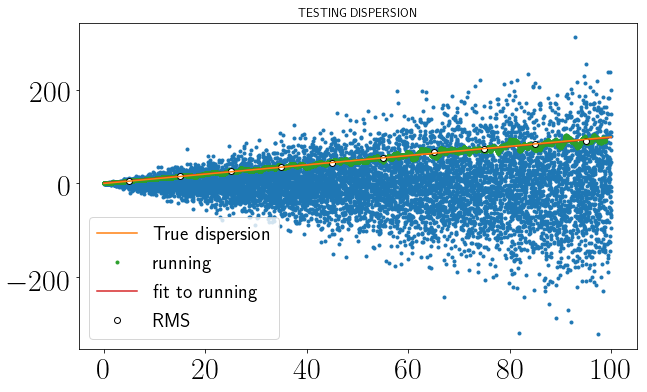

In [13]:
def running_dispersion(x, y, bsize, mad=False):
    
    assert x[0] == np.sort(x)[0], "arrays must be sorted on x."
    
    # Calculate running std of points in bin of bsize
    d, newx = [], []
    for i in range(len(x)):
        if i+bsize < len(x):
            if not mad:
                d.append(np.std(y[i:i + bsize]))
            else:
                d.append(np.median(np.abs(y[i:i + bsize])))
            newx.append(x[i])
    
    return np.array(newx), np.array(d)

def binned_dispersion(x, y, nbins, method="rms"):
    
    d, N, mean = [np.zeros(nbins) for i in range(3)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width
    
    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        mean[i] = np.mean(y[m])
        N[i] = sum(m)
        if method == "std":
            d[i] = np.std(y[m])
        elif method == "mad":
#             d[i] = np.median(np.abs(y[m]))
            d[i] = np.sqrt(np.median(y[m]))
        elif method == "rms":
            d[i] = np.sqrt(np.mean((y[m])**2))
    return mid_bin, d, d/np.sqrt(N), mean

np.random.seed(42)
N = 10000
x = np.random.uniform(0, 100, N)
y = np.random.randn(N)*x
inds = np.argsort(x)
x, y = x[inds], y[inds]

plt.figure(figsize=(10, 6))
plt.plot(x, y, ".")
plt.plot(x, x, zorder=3, label="True dispersion")

newx, d = running_dispersion(x, y, 100, mad=False)
plt.plot(newx, d, ".", label="running")

AT = np.vstack((newx, np.ones_like(newx)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, d))
plt.plot(x, w[0]*x + w[1], label="fit to running")
plt.title("TESTING DISPERSION")

bins, dbins, err, mean = binned_dispersion(x, y, 10, method="rms")
plt.errorbar(bins, dbins, yerr=err, fmt="wo", markeredgecolor="k", label="RMS")

plt.legend()

assert np.isclose(w[0], 1, atol=.1)

In [14]:
# def betterstep(bins, y, **kwargs):
#     new_x = [a for row in zip(bins[:-1], bins[1:]) for a in row]
#     new_y = [a for row in zip(y, y) for a in row]
#     ax = kwargs.pop("ax", plt.gca())
#     return ax.plot(new_x, new_y, **kwargs)

Define the three groups: old, young and binary

In [15]:
# age_bracket = gaia_mc_cool.age.values > .5
binary_prot = 7
age_bracket = gaia_mc_cool.Prot.values > binary_prot
age_bracket &= gaia_mc_cool.age.values < 1.06279416
binaries = gaia_mc_cool.Prot.values < binary_prot

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


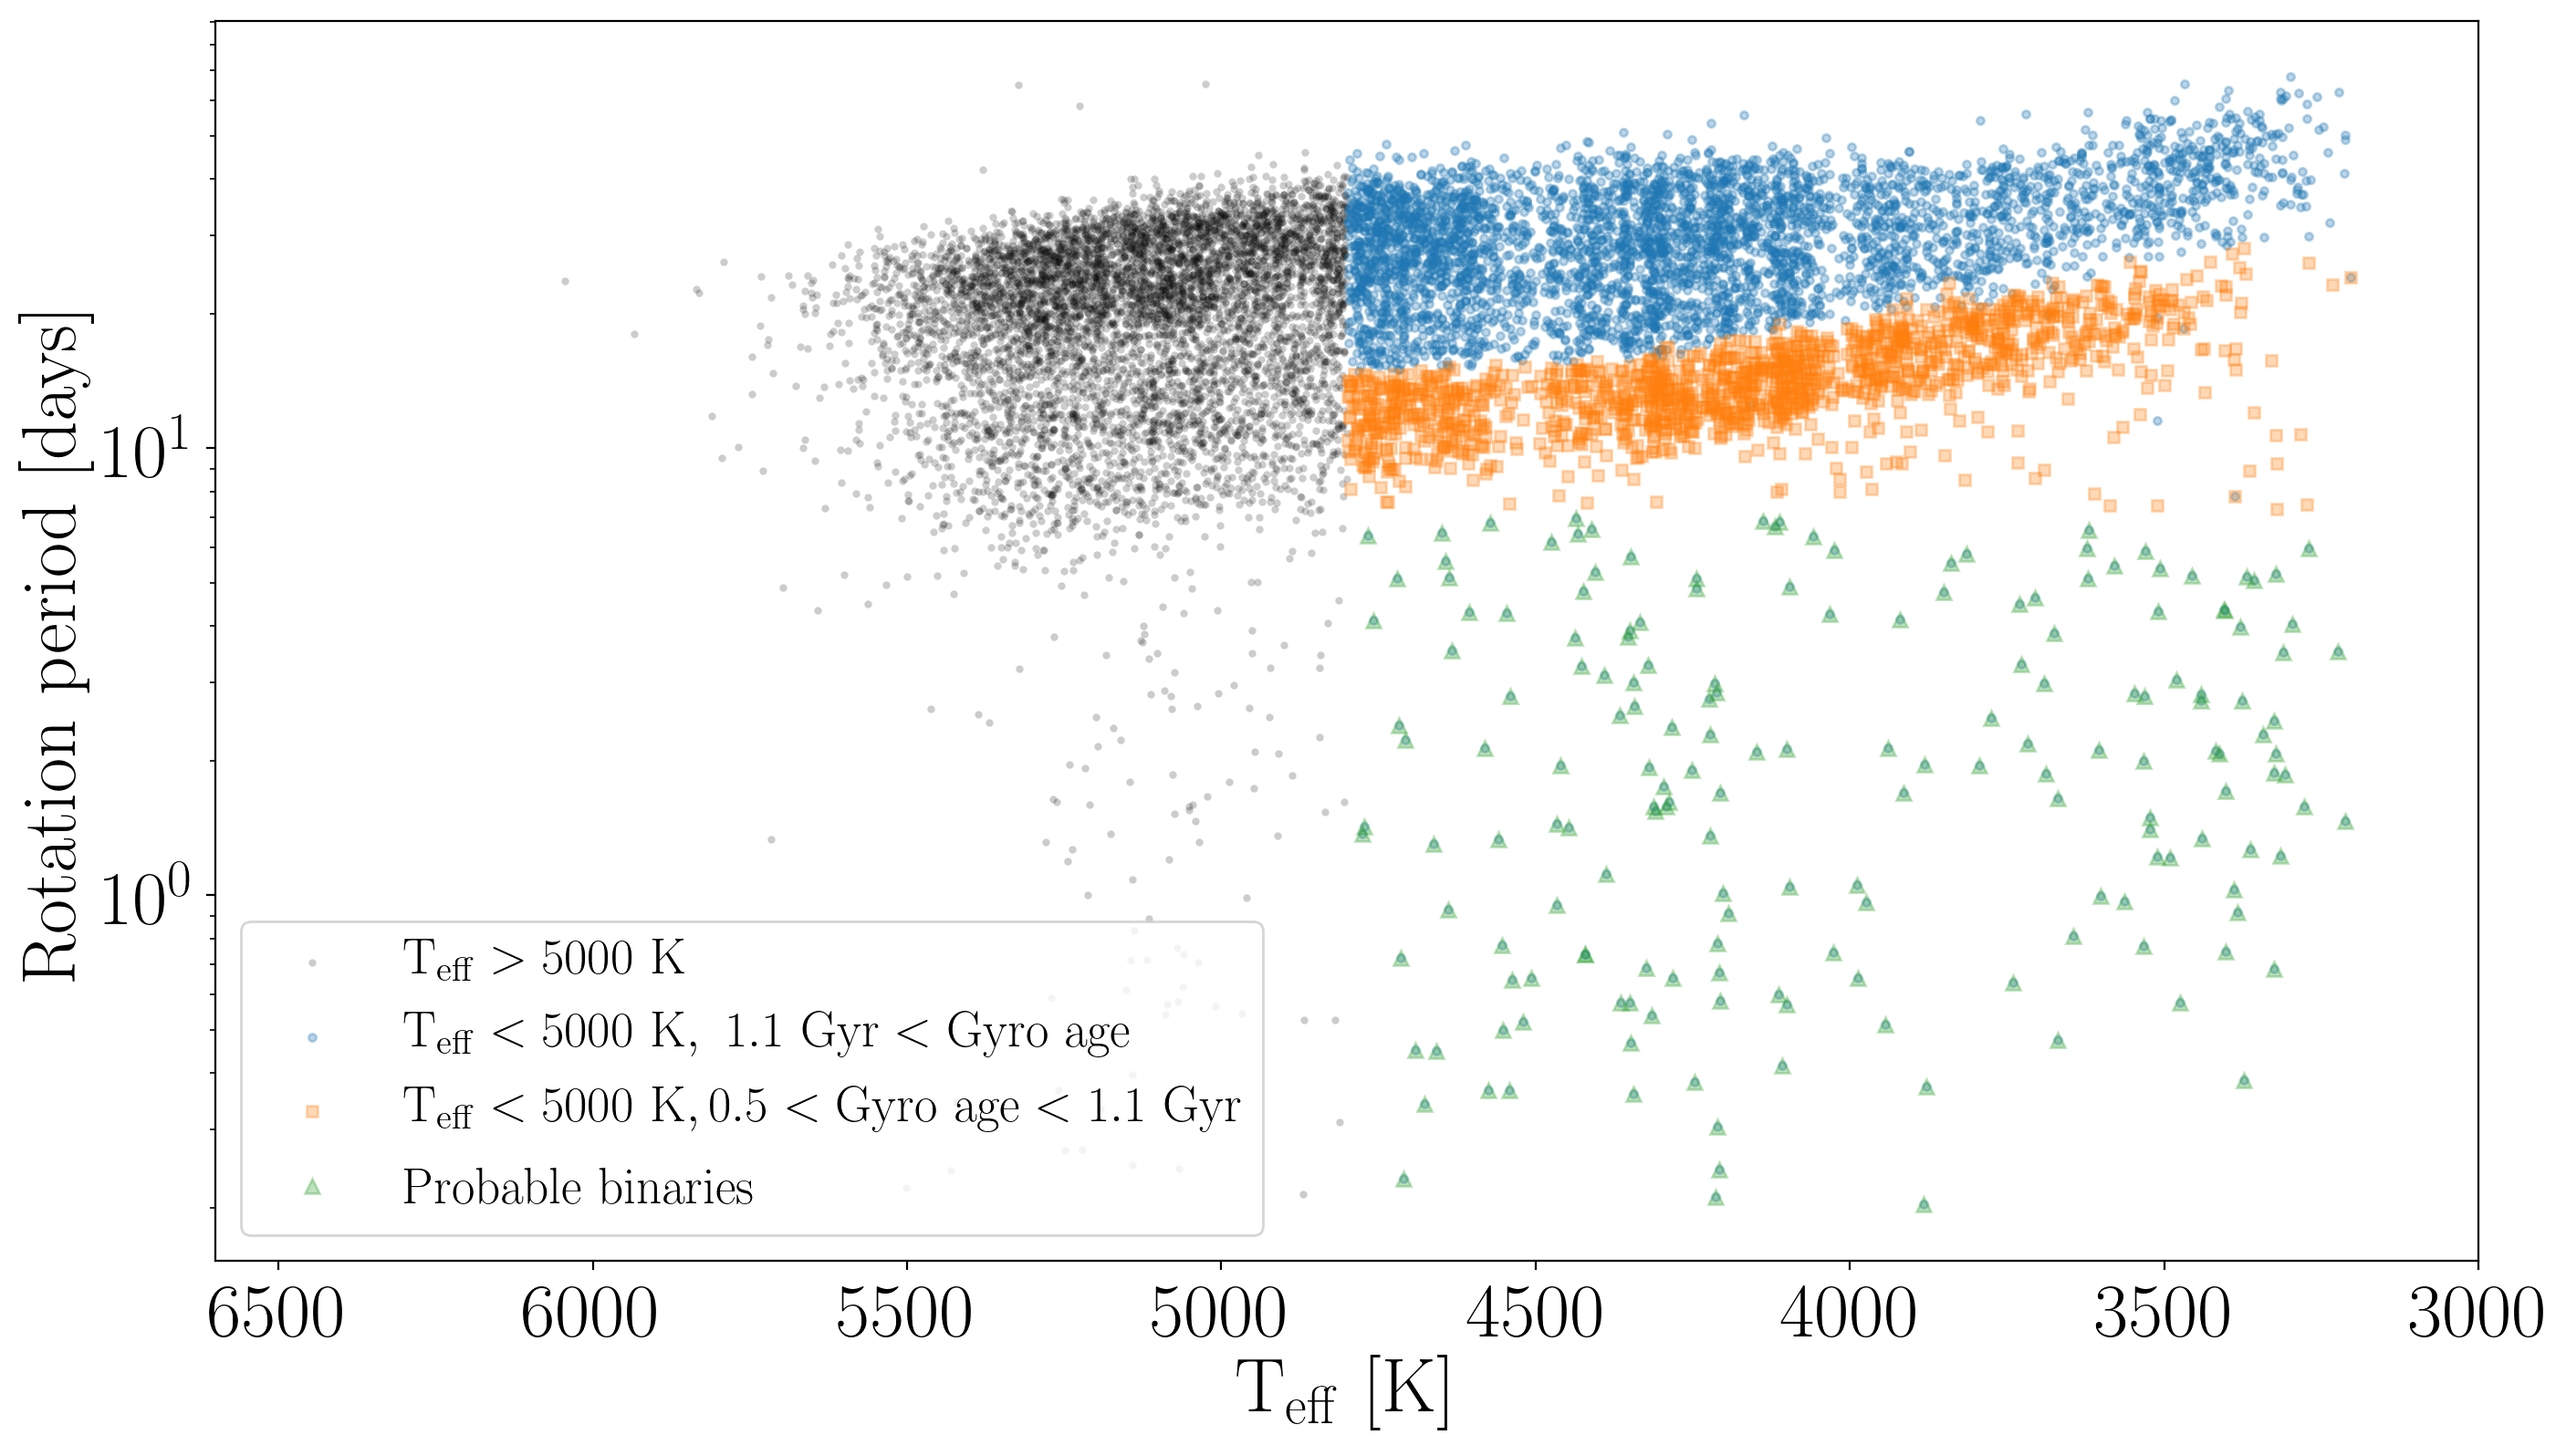

In [16]:
plt.figure(figsize=(16, 9), dpi=200)
# plt.subplot(2, 1, 1)

# # All McQuillan-Gaia stars
# plt.plot(gaia_mc.Teff, gaia_mc.Prot,
#          "k.", zorder=0, alpha=.2, mec="none", label="$\mathrm{McQuillan~{\it et~al.}~(2014)}$")
# plt.xlim(6600, 3000)
# plt.ylabel("$\mathrm{Rotation~period~[days]}$");
# plt.yscale("log")

# plt.subplot(2, 1, 2)

# All McQuillan-Gaia stars that are not equal-mass binaries or subgiants.
plt.plot(gaia_mc_hot.Teff, gaia_mc_hot.Prot,
         "k.", zorder=0, alpha=.2, mec="none", label="$\mathrm{T_{eff} > 5000~K}$")

# Cool stars
plt.plot(gaia_mc_cool.Teff.values[~age_bracket], gaia_mc_cool.Prot.values[~age_bracket],
         "o", ms=3, color="C0", zorder=1, alpha=.3,
         label="$\mathrm{T_{eff} < 5000~K,~1.1~Gyr < Gyro~age}$")

# Gap stars
plt.plot(gaia_mc_cool.Teff.values[age_bracket], gaia_mc_cool.Prot.values[age_bracket],
         "s", color="C1", ms=4, zorder=2, alpha=.3,
         label="$\mathrm{T_{eff} < 5000~K, 0.5 < Gyro~age < 1.1~Gyr}$")

# Binaries
plt.plot(gaia_mc_cool.Teff.values[binaries], gaia_mc_cool.Prot.values[binaries],
         "^", color="C2", zorder=2, alpha=.3,
         label="$\mathrm{Probable~binaries}$")

# plt.plot(df.Teff, df.Prot, ".", color="C0", alpha=.99, ms=12, zorder=1)
# plt.plot(cool.Teff, cool.Prot, ".", color="C1", alpha=.99, ms=12, zorder=1)
# plt.plot(cool.Teff[age_bracket], cool.Prot[age_bracket], ".", color="C2", alpha=.99, ms=12, zorder=1)

xs = np.linspace(3500, 5000, 100)
plt.xlim(6600, 3000)
plt.yscale("log")
plt.legend()
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");
plt.subplots_adjust(hspace=None)
plt.savefig("paper/period_teff.pdf")

Plot zoom in.

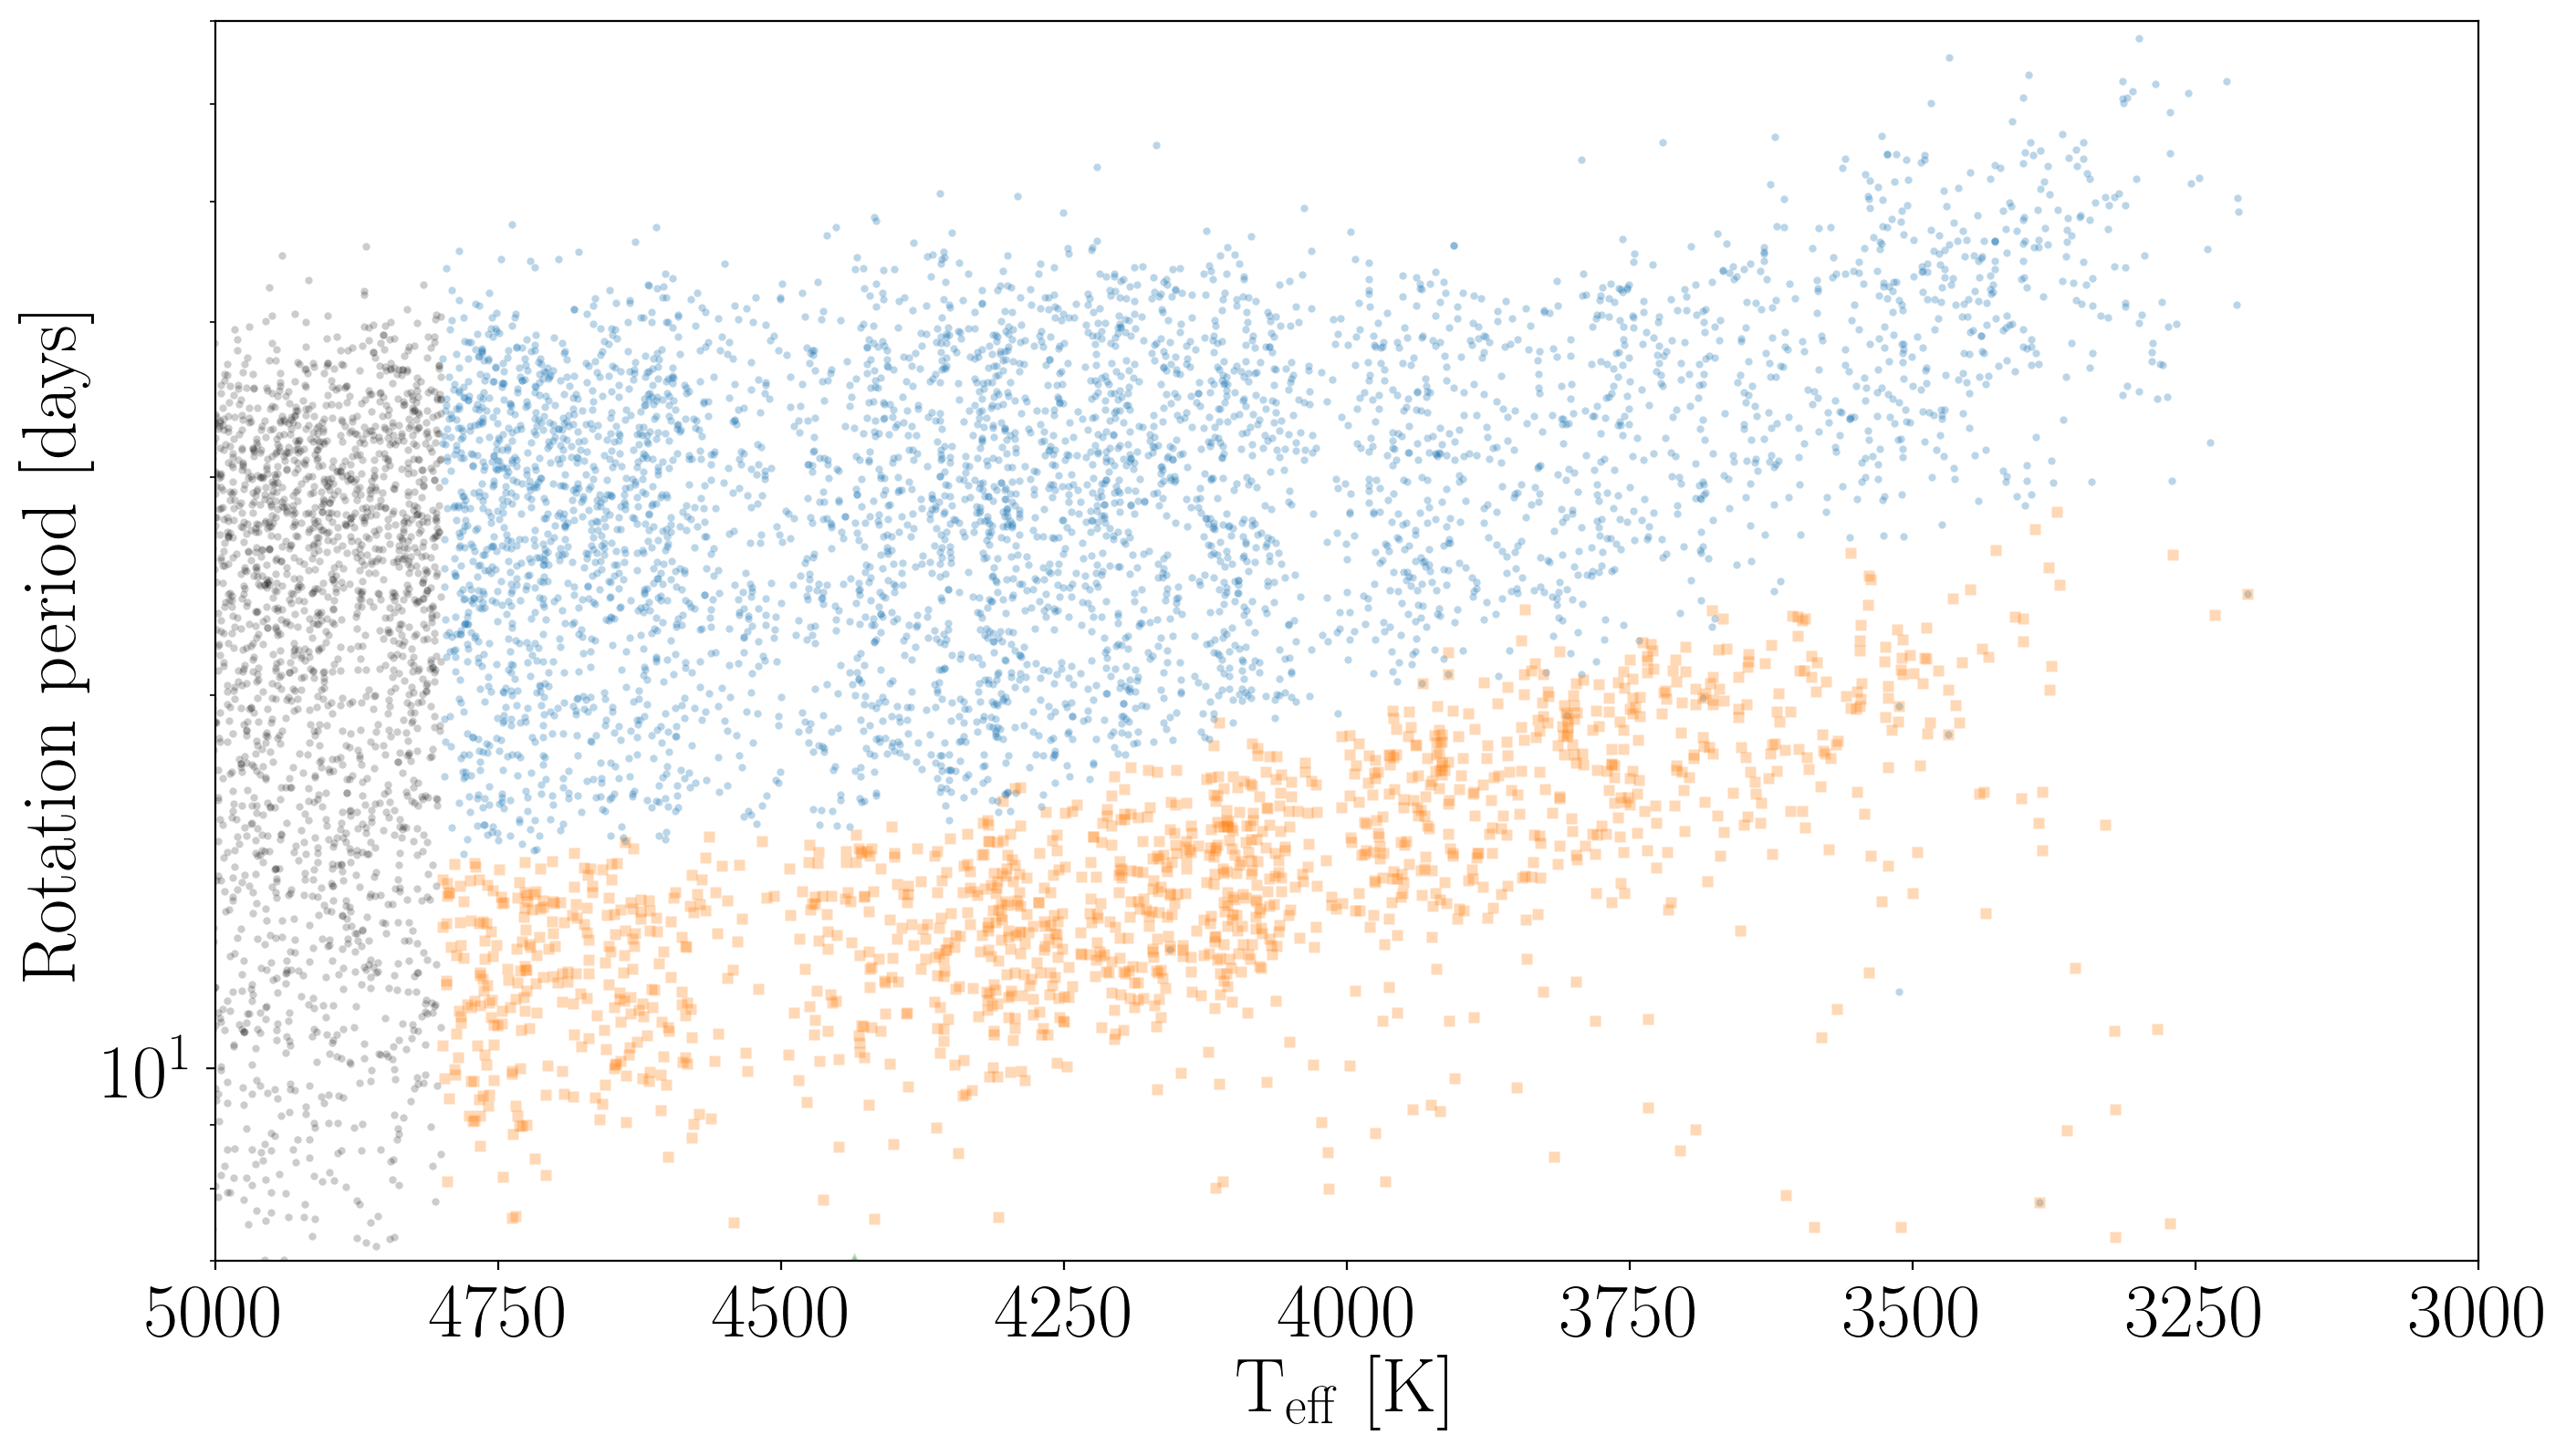

In [17]:
plt.figure(figsize=(16, 9), dpi=200)

# All McQuillan-Gaia stars that are not equal-mass binaries or subgiants.
plt.plot(gaia_mc_hot.Teff, gaia_mc_hot.Prot,
         "k.", zorder=0, alpha=.2, mec="none", label="$\mathrm{T_{eff} > 5000~K}$")

# Cool stars
plt.plot(gaia_mc_cool.Teff.values[~age_bracket], gaia_mc_cool.Prot.values[~age_bracket],
         "o", ms=3, color="C0", zorder=1, alpha=.3, mec="none",
         label="$\mathrm{T_{eff} < 5000~K,~1.1~Gyr < Gyro~age}$")

# Gap stars
plt.plot(gaia_mc_cool.Teff.values[age_bracket], gaia_mc_cool.Prot.values[age_bracket],
         "s", color="C1", ms=4, zorder=2, alpha=.3, mec="none",
         label="$\mathrm{T_{eff} < 5000~K, 0.5 < Gyro~age < 1.1~Gyr}$")

# Binaries
plt.plot(gaia_mc_cool.Teff.values[binaries], gaia_mc_cool.Prot.values[binaries],
         "^", color="C2", zorder=2, alpha=.3,
         label="$\mathrm{Probable~binaries}$")

xs = np.linspace(3500, 5000, 100)
plt.xlim(5000, 3000)
plt.yscale("log")
plt.ylim(7, 70)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

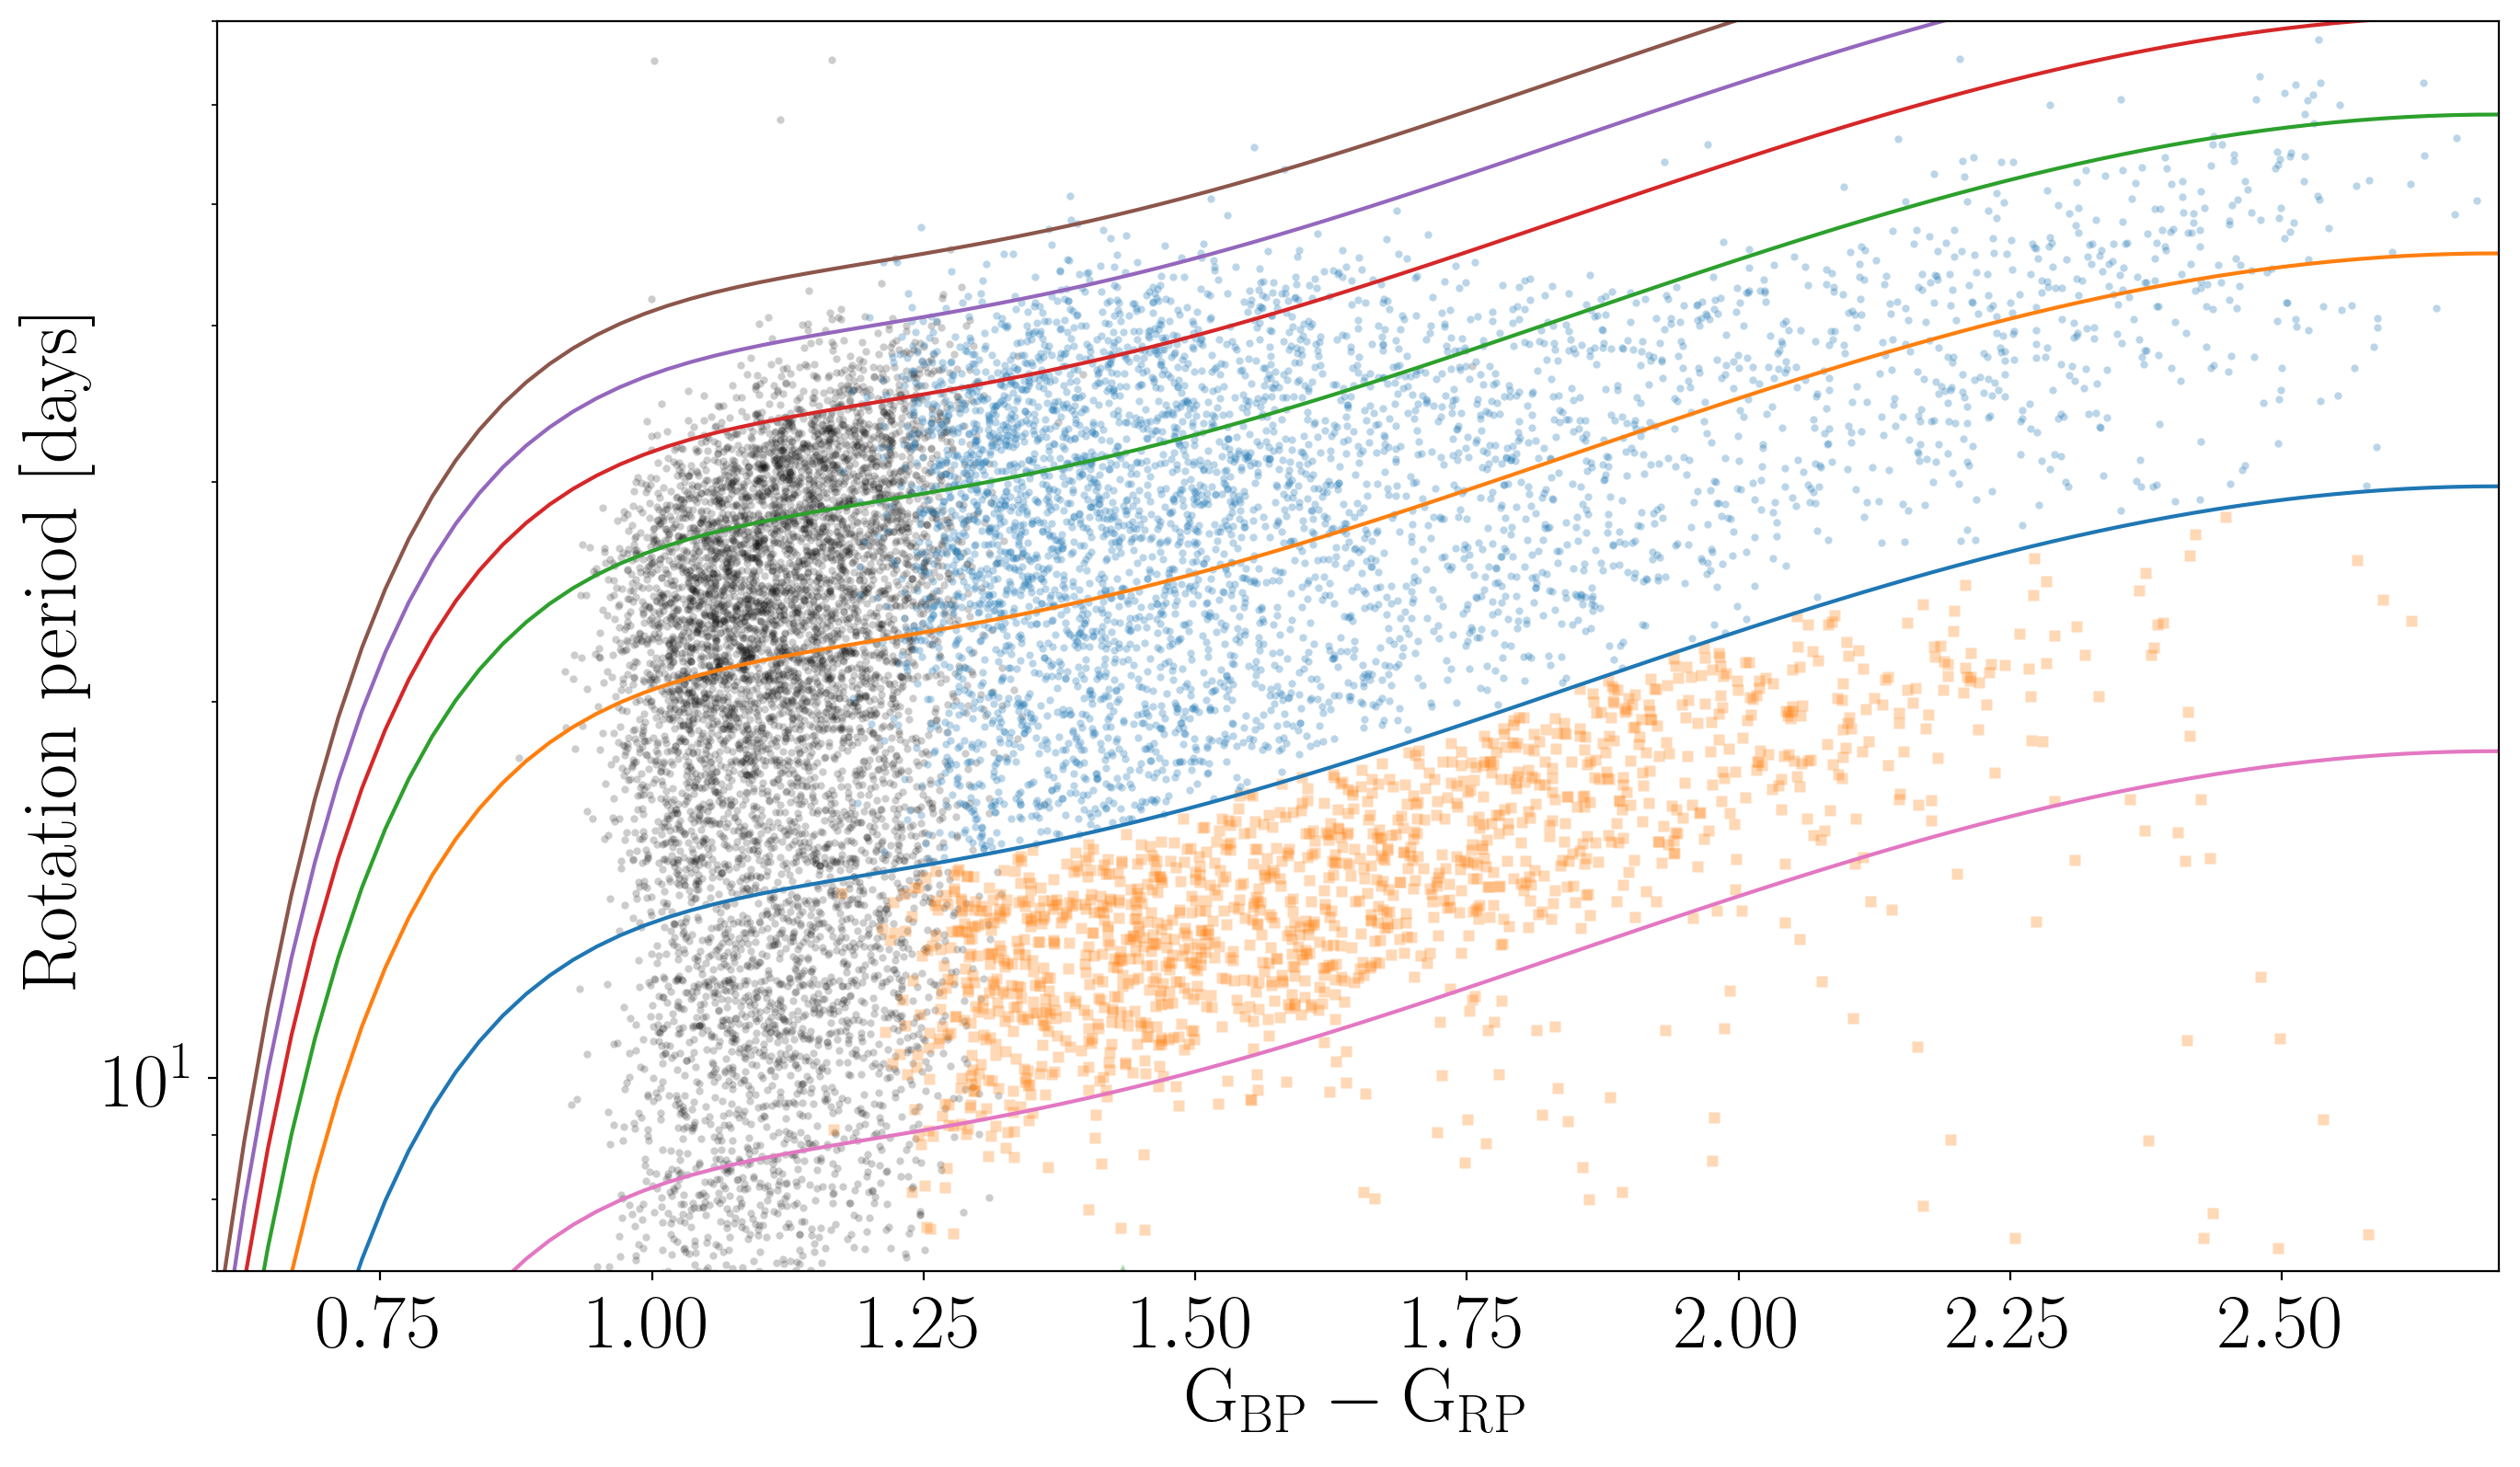

In [18]:
plt.figure(figsize=(16, 9), dpi=200)

hot_bprp = gaia_mc_hot.phot_bp_mean_mag - gaia_mc_hot.phot_rp_mean_mag
cool_bprp = gaia_mc_cool.phot_bp_mean_mag - gaia_mc_cool.phot_rp_mean_mag

# All McQuillan-Gaia stars that are not equal-mass binaries or subgiants.
plt.plot(hot_bprp, gaia_mc_hot.Prot,
         "k.", zorder=0, alpha=.2, mec="none", label="$\mathrm{T_{eff} > 5000~K}$")

# Cool stars
plt.plot(cool_bprp.values[~age_bracket],
         gaia_mc_cool.Prot.values[~age_bracket],
         "o", ms=3, color="C0", zorder=1, alpha=.3, mec="none",
         label="$\mathrm{T_{eff} < 5000~K,~1.1~Gyr < Gyro~age}$")

# Gap stars
plt.plot(cool_bprp.values[age_bracket],
         gaia_mc_cool.Prot.values[age_bracket],
         "s", color="C1", ms=4, zorder=2, alpha=.3, mec="none",
         label="$\mathrm{T_{eff} < 5000~K, 0.5 < Gyro~age < 1.1~Gyr}$")

# Binaries
plt.plot(cool_bprp.values[binaries],
         gaia_mc_cool.Prot.values[binaries],
         "^", color="C2", zorder=2, alpha=.3,
         label="$\mathrm{Probable~binaries}$")

# xs = np.linspace(3500, 5000, 100)
# plt.xlim(5000, 3000)
from stardate.lhf import gk_rotation_model, gyro_model_rossby

bprp = np.linspace(.56, 2.7, 100)
for a in np.arange(1.06279416, 7, 1):
    logp = gk_rotation_model(np.log10(a*1e9), bprp)
    plt.plot(bprp, 10**logp)
logp = gk_rotation_model(np.log10(.5*1e9), bprp)
plt.plot(bprp, 10**logp)

logp = gk_rotation_model(np.log10(1.65*1e9), bprp)
# plt.plot(bprp, 10**logp, ls="--")

plt.yscale("log")
plt.ylim(7, 70)
plt.xlim(.6, 2.7)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");

Why are there missing old M dwarfs?

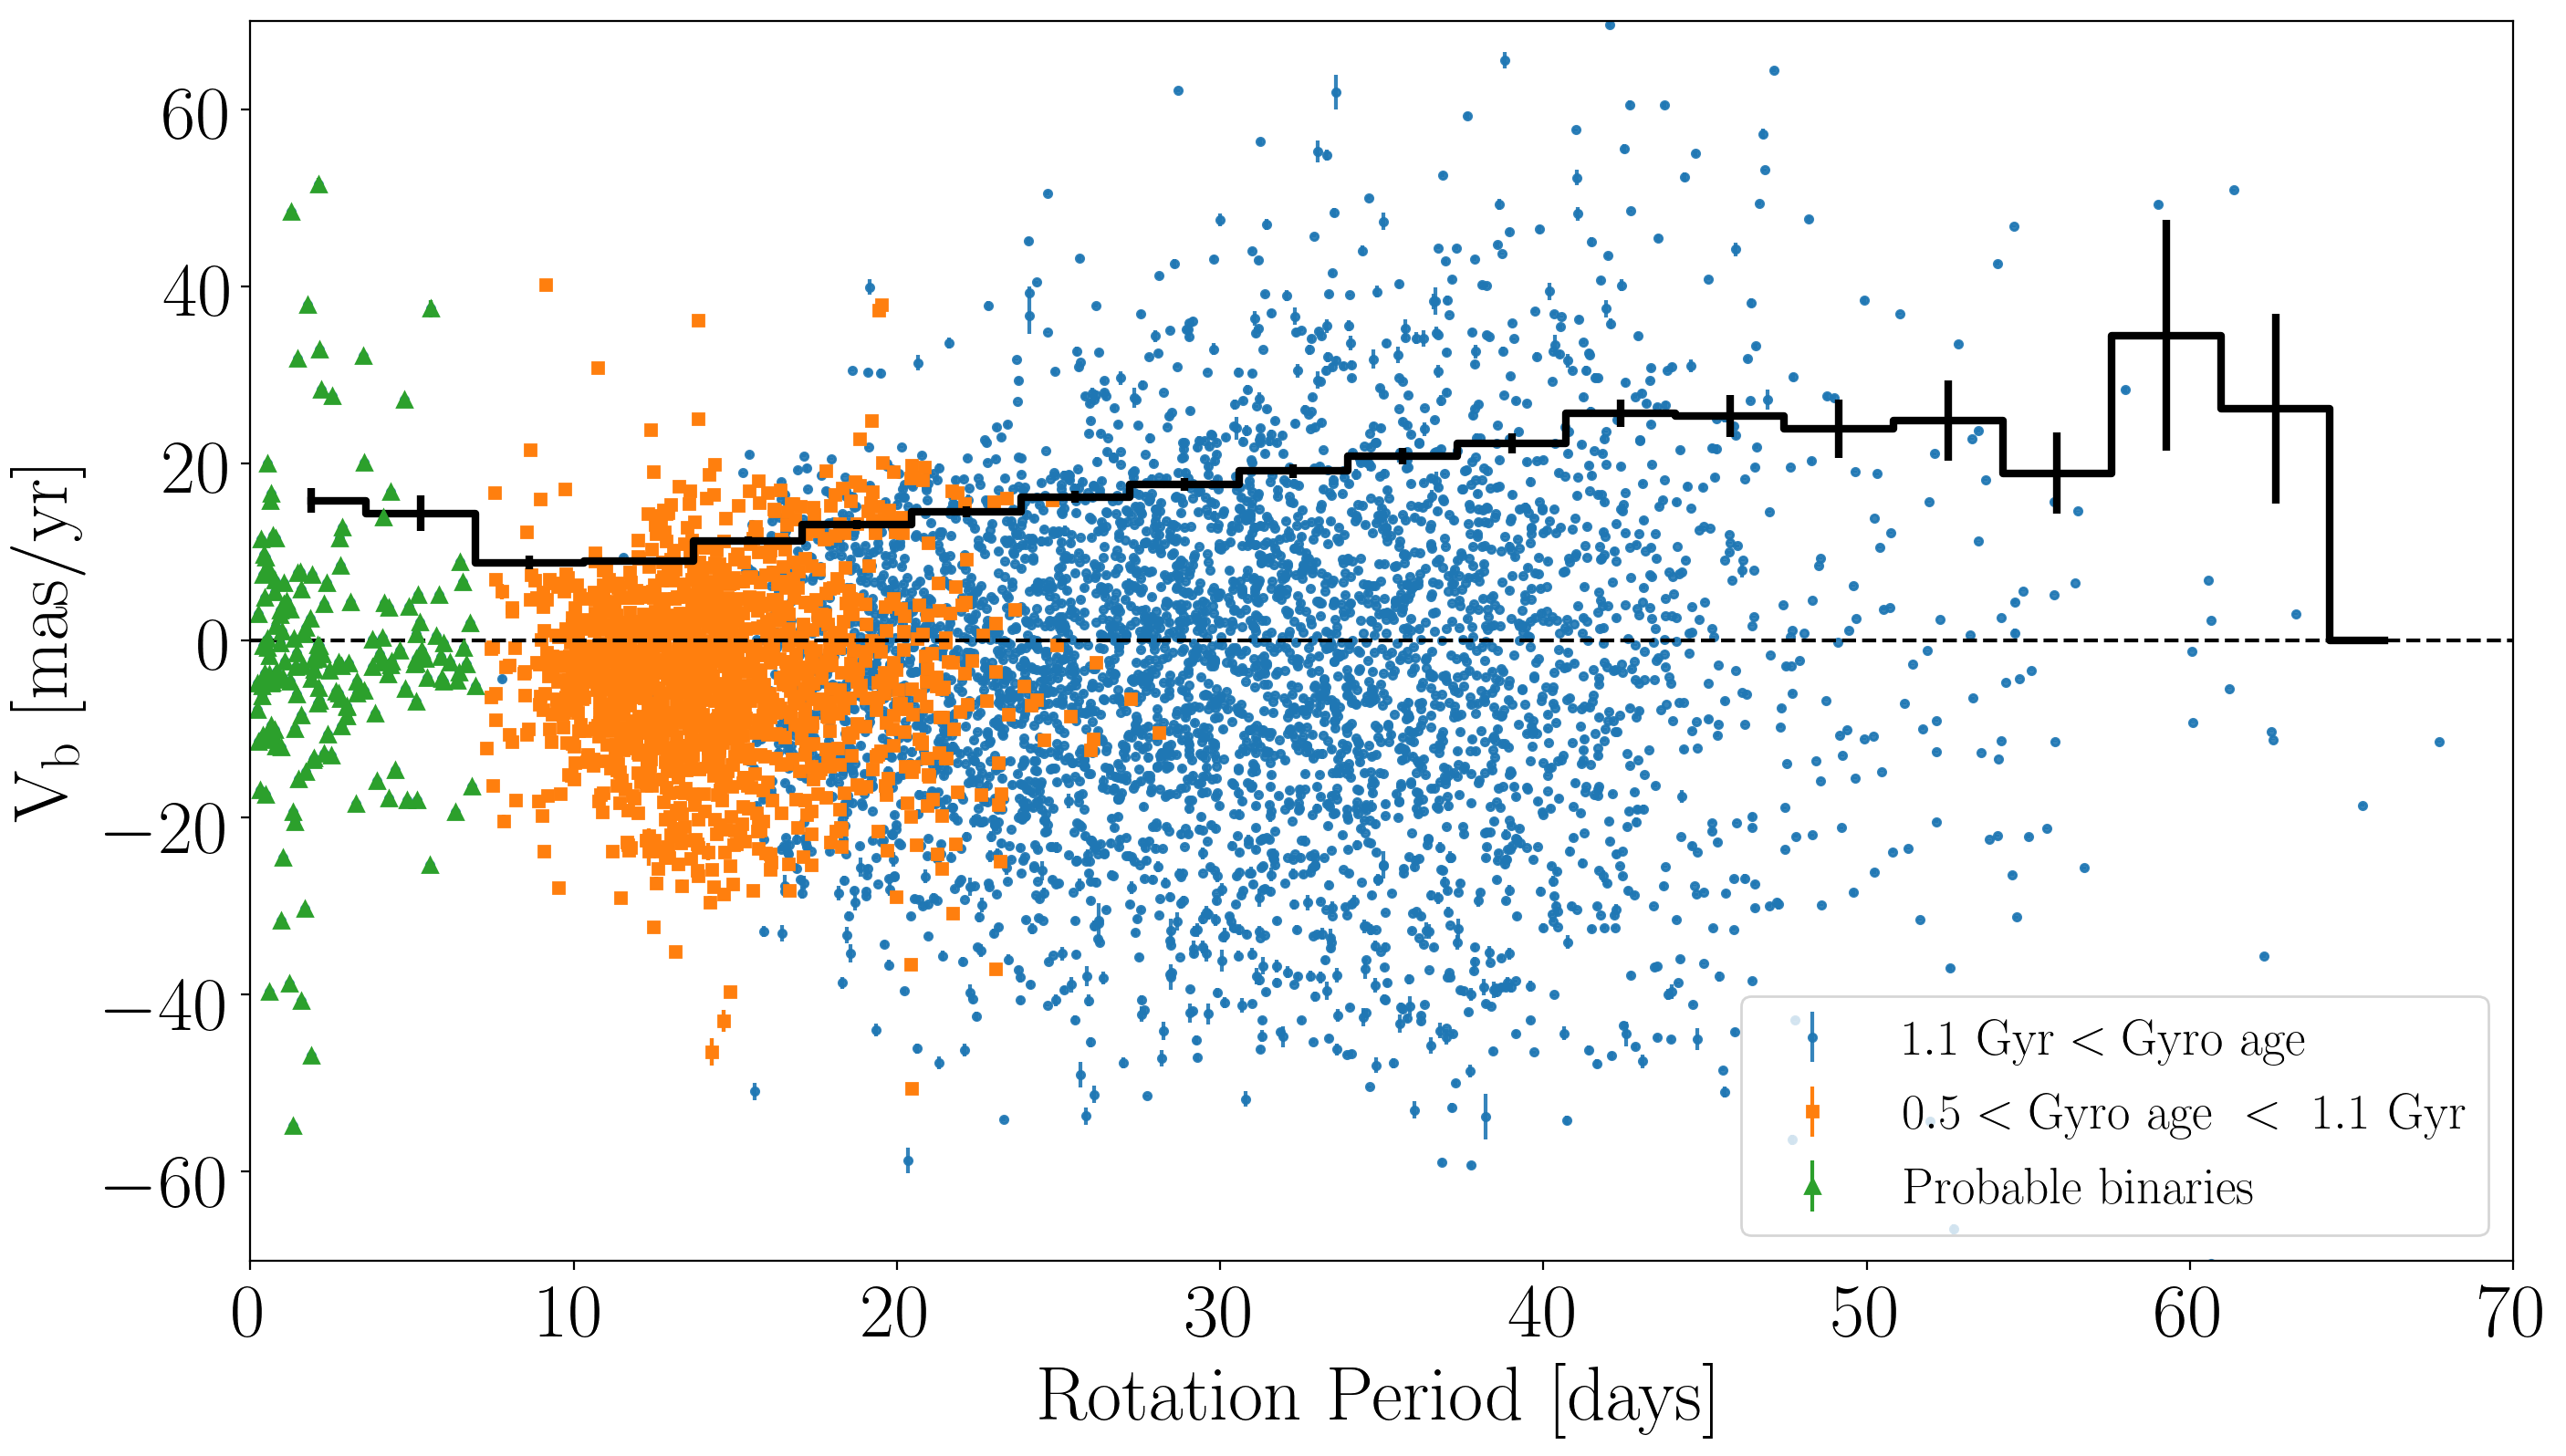

In [24]:
bins, dbins, err, mean = binned_dispersion(gaia_mc_cool.Prot.values, gaia_mc_cool.vb.values, 20, method="std")

plt.figure(figsize=(16, 9), dpi=200)

# Old stars
plt.errorbar(gaia_mc_cool.Prot.values, gaia_mc_cool.vb.values, yerr=gaia_mc_cool.vb_err.values,
         fmt=".", color="C0", zorder=0, alpha=.9, label="$\mathrm{1.1~Gyr < Gyro~age}$")

# Gap stars
plt.errorbar(gaia_mc_cool.Prot.values[age_bracket], gaia_mc_cool.vb.values[age_bracket],
             yerr=gaia_mc_cool.vb_err.values[age_bracket],
             fmt="s", color="C1", ms=4, zorder=1, label="$\mathrm{0.5 < Gyro~age~<~1.1~Gyr}$")

# Binaries
plt.errorbar(gaia_mc_cool.Prot.values[binaries], gaia_mc_cool.vb.values[binaries],
             yerr=gaia_mc_cool.vb_err.values[binaries],
             fmt="^", color="C2", zorder=2, label="$\mathrm{Probable~binaries}$")

plt.step(bins, dbins, where="mid", color="k", lw=3, label=None) #"$\sigma_{\mathrm{pm,~b}}$")

plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", elinewidth=3, ms=1)
# plt.yscale("log")
plt.xlabel("$\mathrm{Rotation~Period~[days]}$")
plt.ylabel("$\mathrm{V_b~[mas/yr]}$")
# plt.ylim(.1, 160)
plt.xlim(0, 70)
plt.ylim(-70, 70)
plt.legend()
plt.axhline(0, color="k", ls="--")
plt.savefig("paper/rotation_vb_dispersion.pdf")

Remove 'young' stars.

In [25]:
gmc = gaia_mc_cool.iloc[gaia_mc_cool.log_age.values > 8.5]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


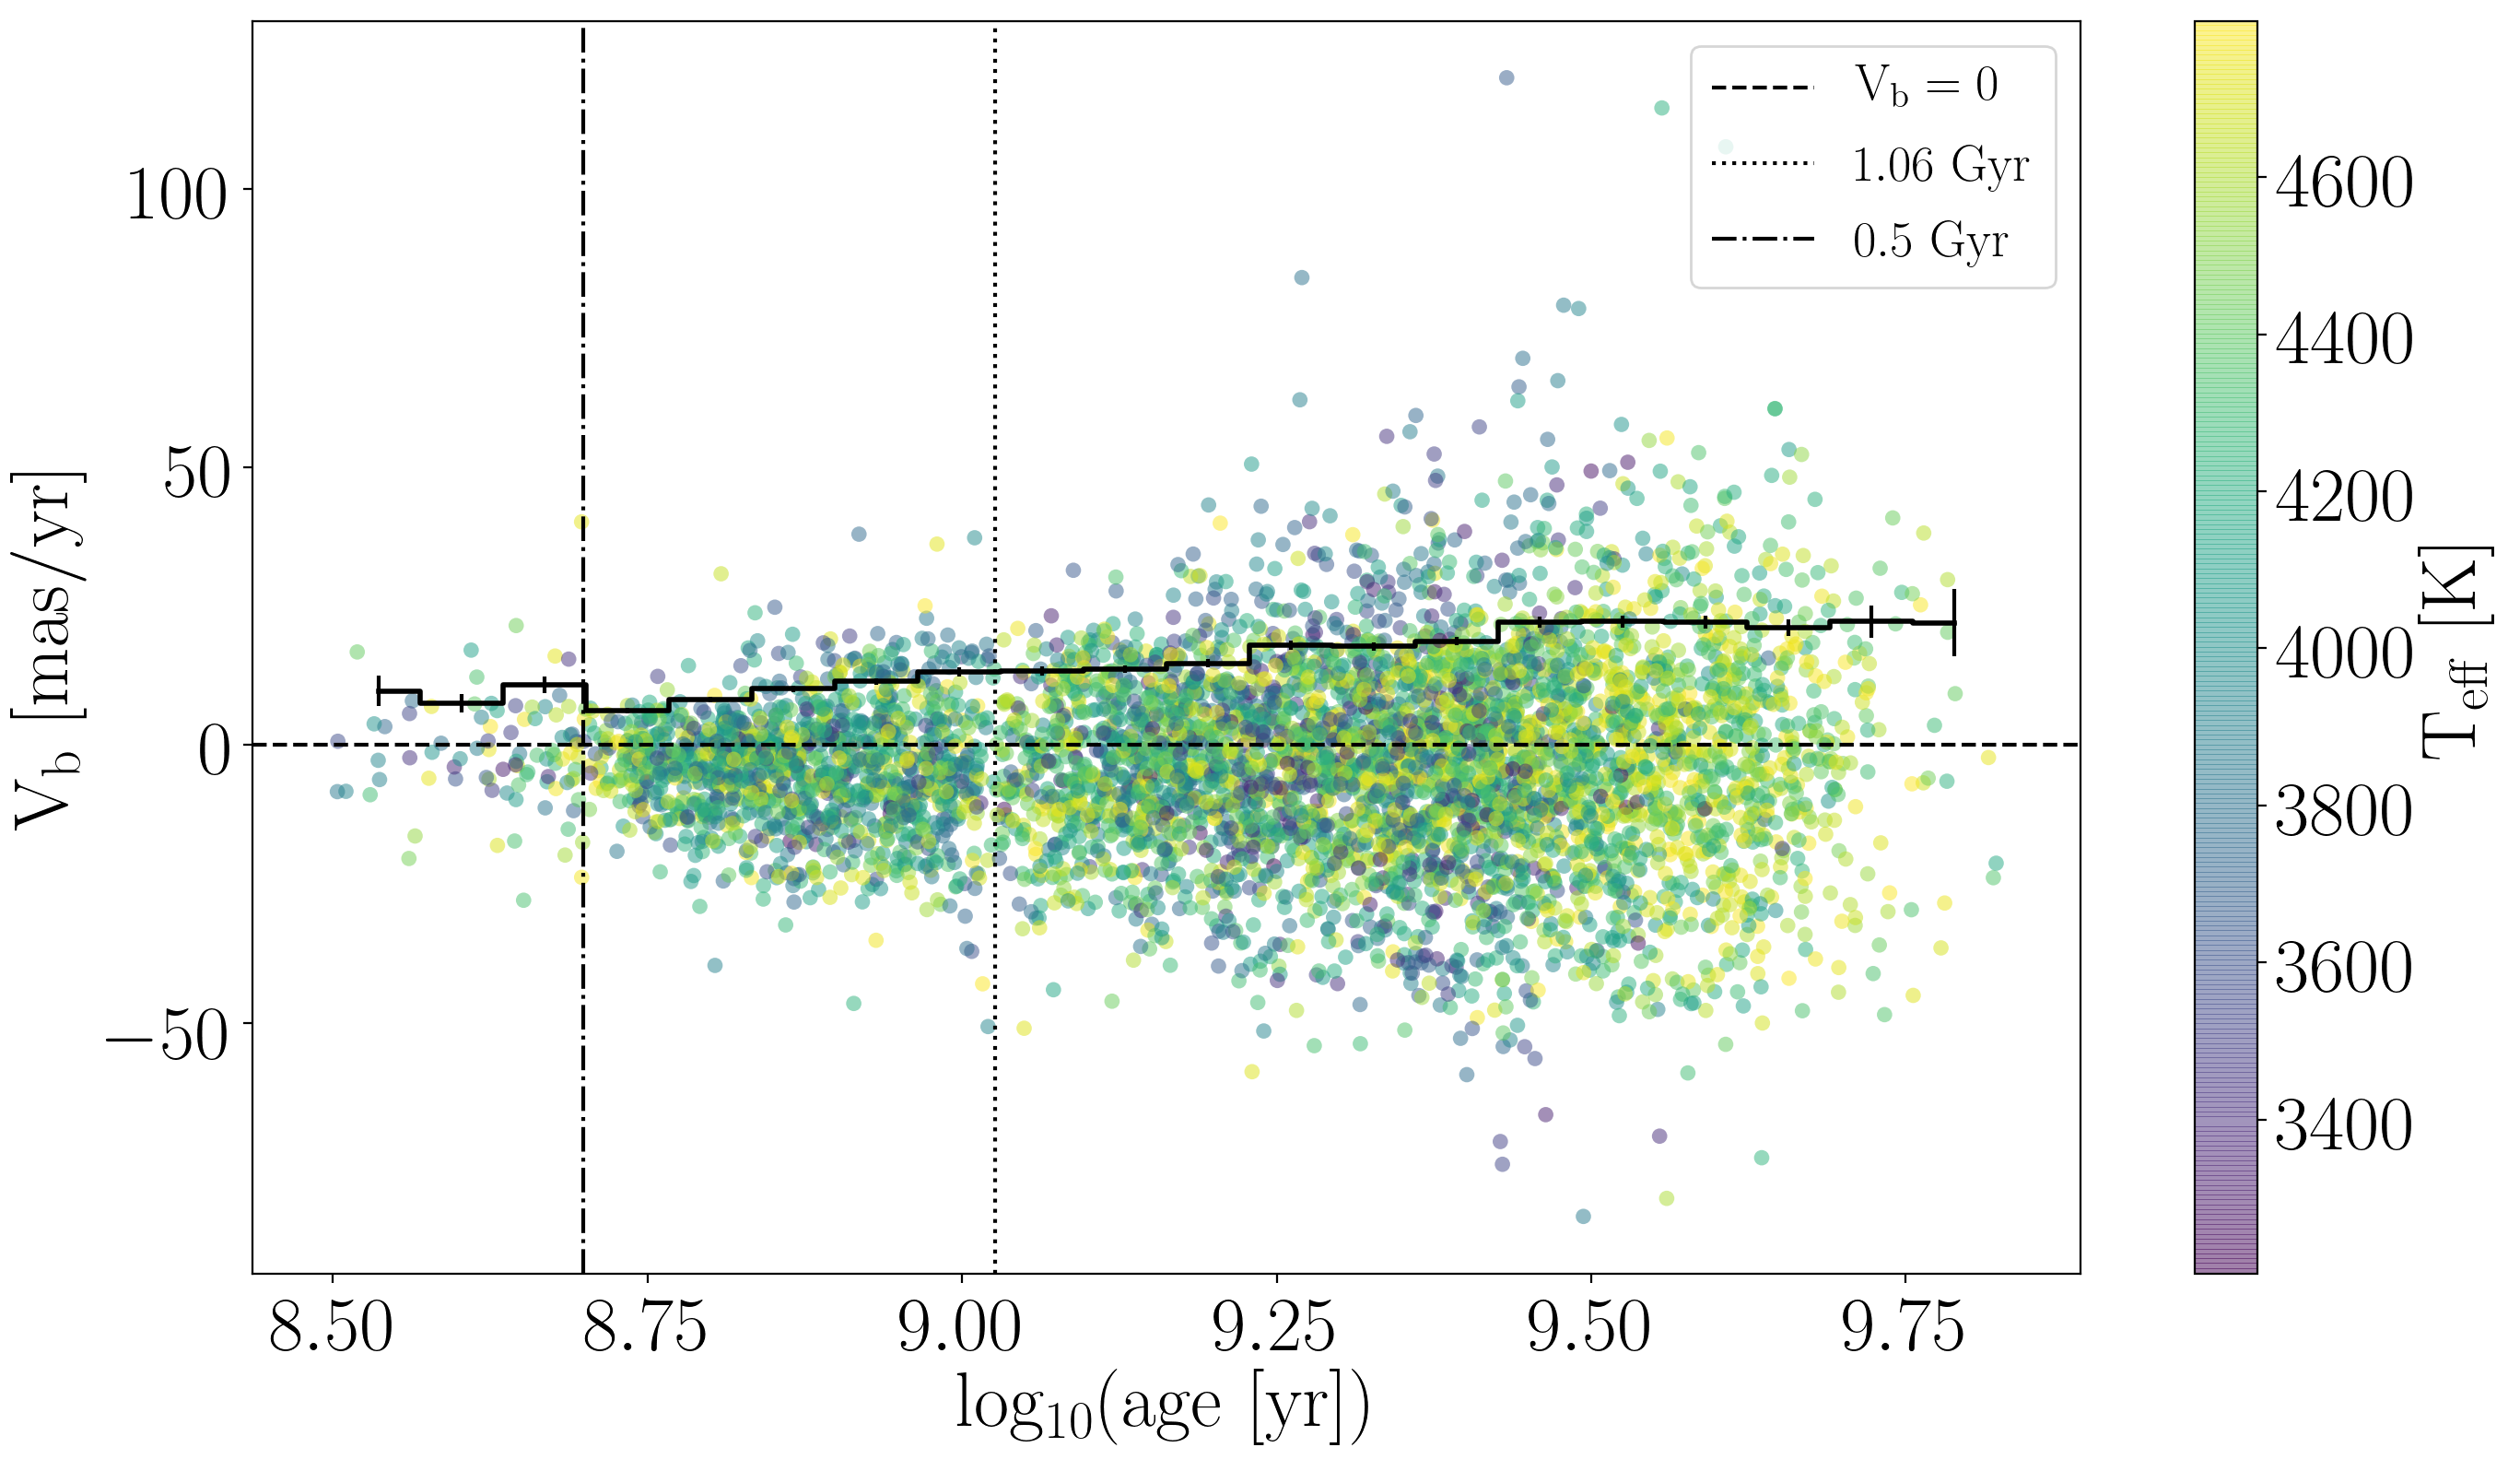

In [27]:
bins, dbins, err, mean = binned_dispersion(gmc.log_age.values, gmc.vb.values, 20, method="std")

plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gmc.log_age.values, gmc.vb.values, c=gmc.Teff, zorder=0, alpha=.5, edgecolor="none",
            rasterized=True)
plt.colorbar(label="$\mathrm{T_{eff}~[K]}$")
plt.step(bins, dbins, where="mid", lw=2, color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
# plt.yscale("log")
plt.xlabel("$\mathrm{log_{10}(age~[yr])}$")
plt.ylabel("$\mathrm{V_b~[mas/yr]}$")
plt.axhline(0, color="k", ls="--", label="$\mathrm{V_b = 0}$")
plt.axvline(np.log10(1.06279416*1e9), color="k", ls=":", label="$\mathrm{1.06~Gyr}$")
plt.axvline(np.log10(.5*1e9), color="k", ls="-.", label="$\mathrm{0.5~Gyr}$")
plt.legend()

# plt.ylim(-50, 50)
plt.savefig("paper/age_vb_dispersion.pdf")

Plot histograms for cool and hot stars in different age ranges.

Look at just the stalling stars.

In [265]:
kstall = gmc.Prot > 10
kstall &= gmc.Prot < 16
kstall &= gmc.Teff > 4000

gstall = gaia_mc_hot.Prot.values > 10
gstall &= gaia_mc_hot.Prot.values < 16
# gstall = gaia_mc_hot.Prot.values > 7
# gstall &= gaia_mc_hot.Prot.values < 12
gstall &= gaia_mc_hot.Teff.values < 5800
gstall &= gaia_mc_hot.Teff.values > 5200
gstall &= gaia_mc_hot.log_age.values > 8.5

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [266]:
dwarfs = gaia_mc.iloc[gaia_mc.g_final.values > 8]

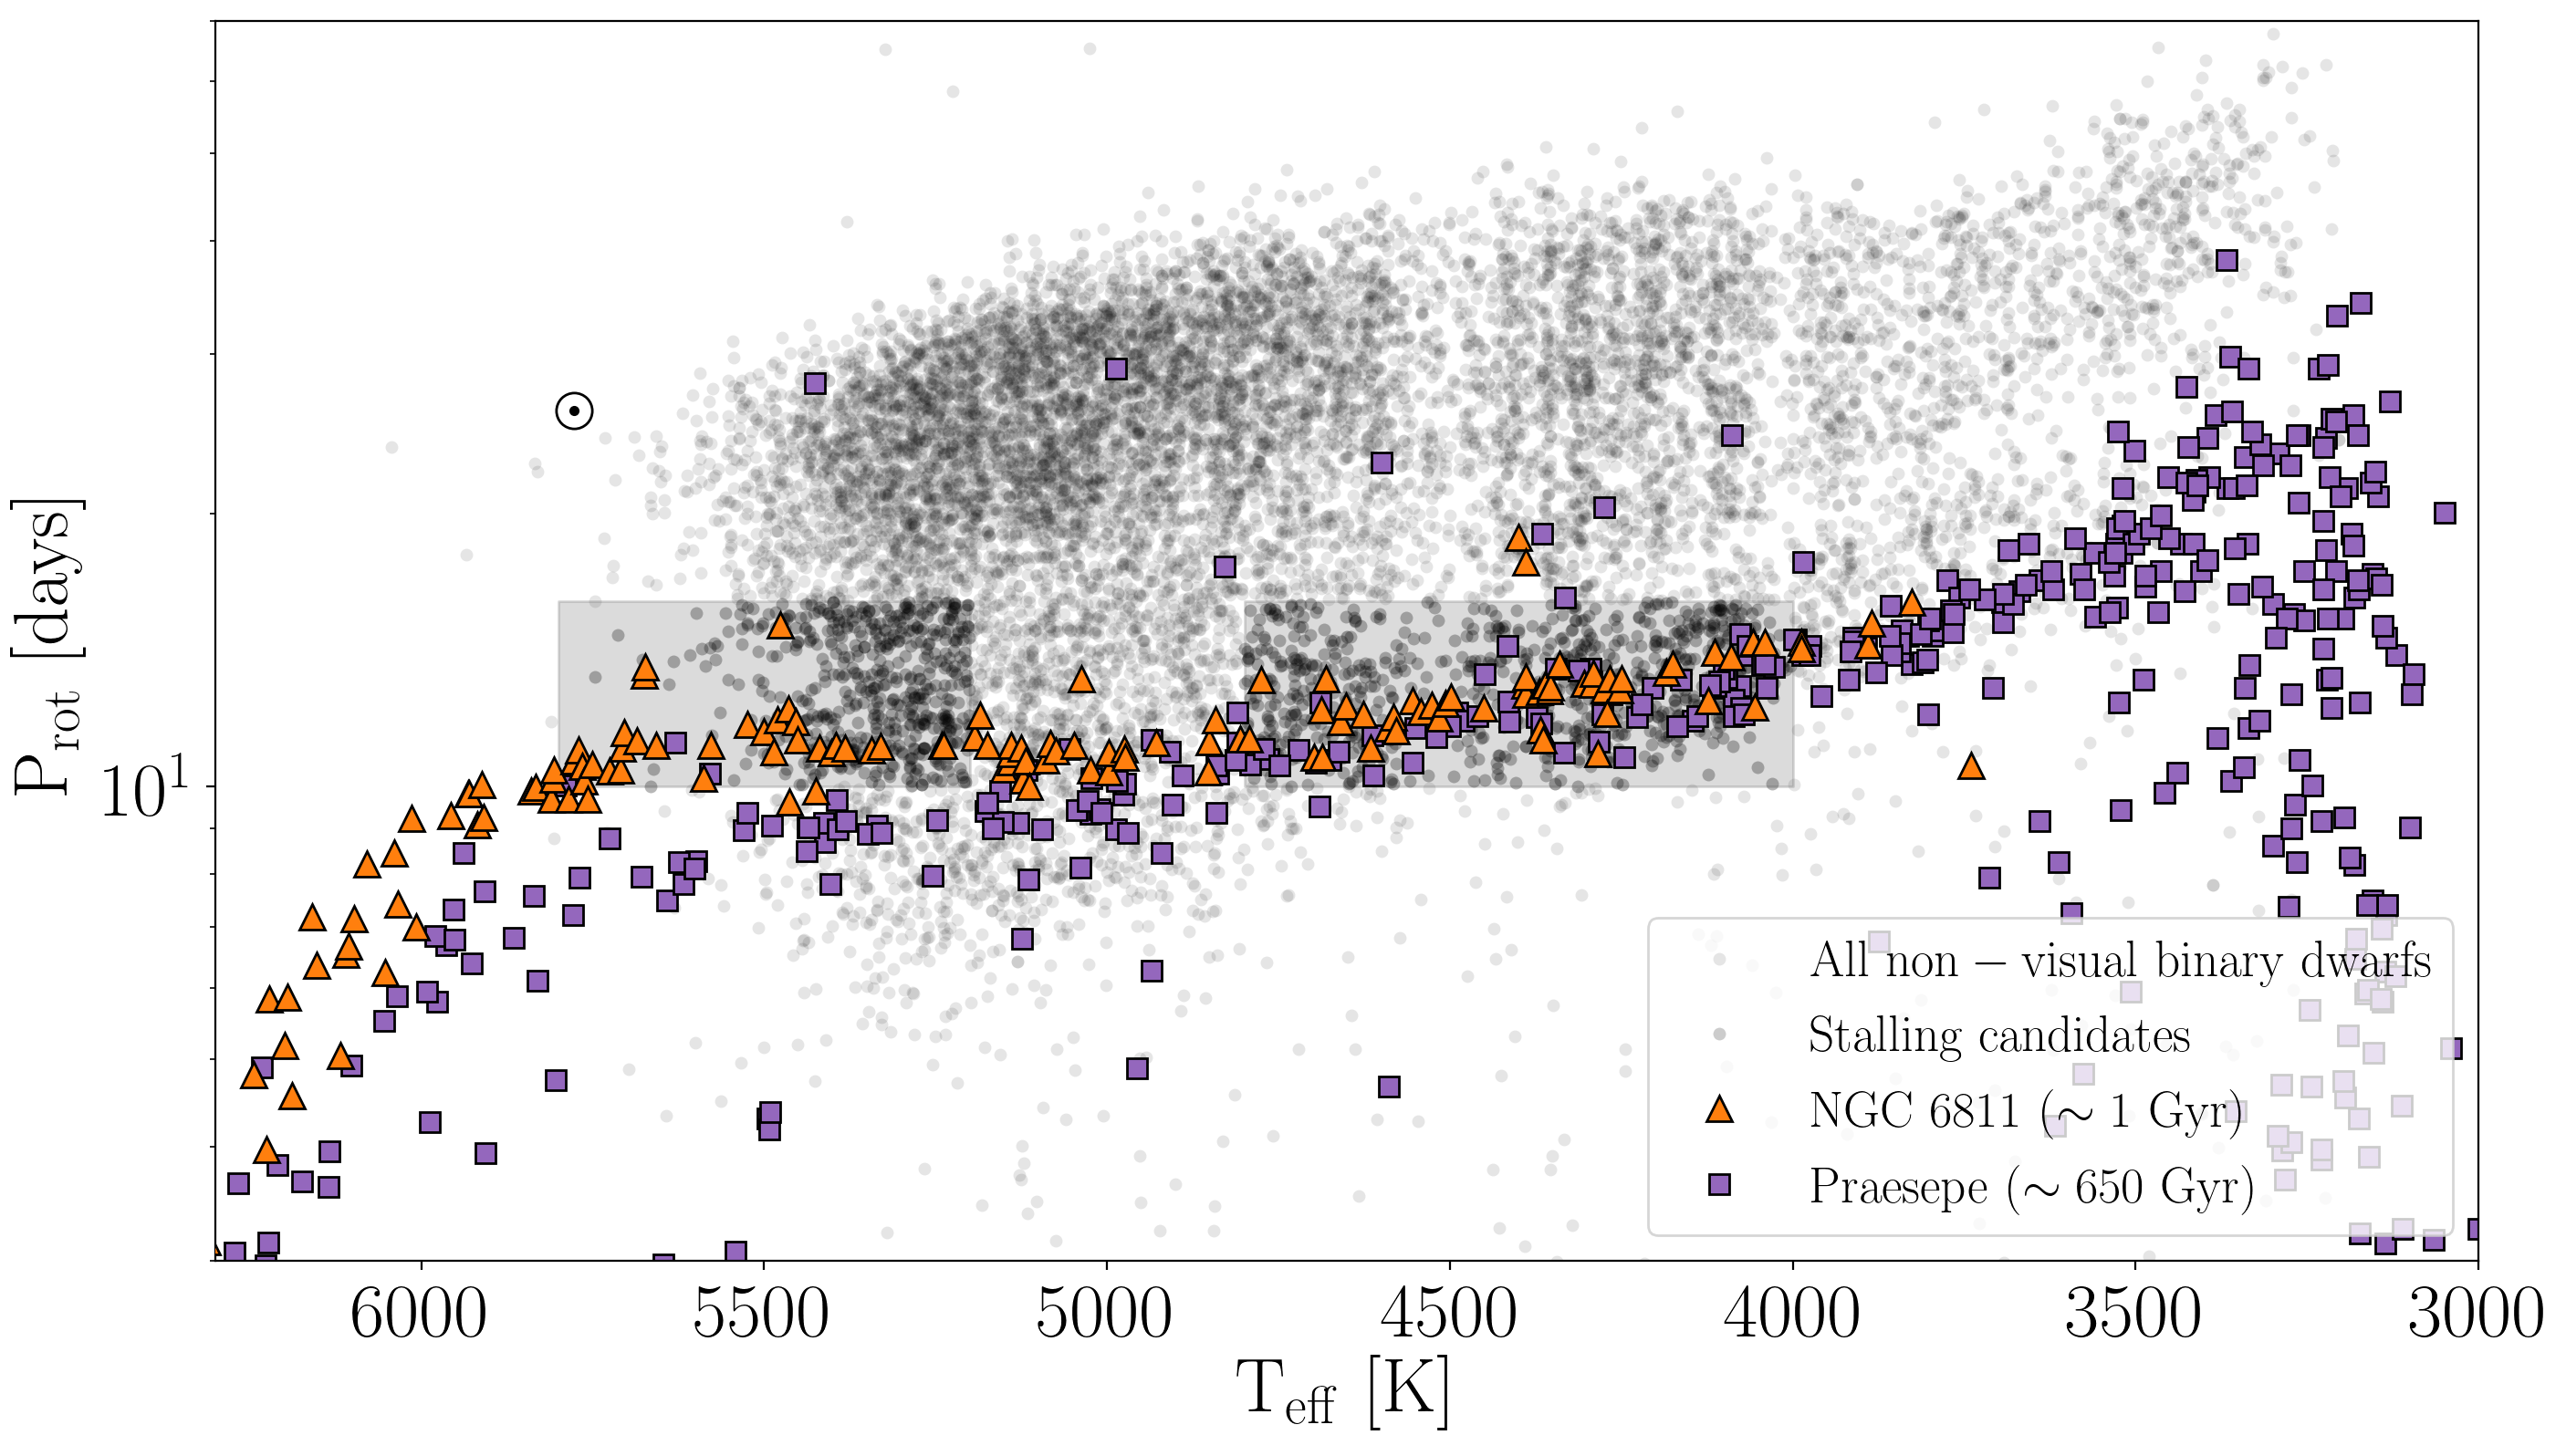

In [270]:
ngc6811 = pd.read_csv("NGC6811.csv")
pr = pd.read_csv("praesepe_teffs.csv")

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(dwarfs.Teff, dwarfs.Prot, "k.", alpha=.1, zorder=0, mec="none", ms=10,
         label="$\mathrm{All~non-visual~binary~dwarfs}$")

plt.plot(gmc.Teff[kstall], gmc.Prot[kstall], "k.", ms=10,
         alpha=.2, zorder=1, mec="none", label="$\mathrm{Stalling~candidates}$")

plt.plot(gaia_mc_hot.Teff[gstall], gaia_mc_hot.Prot[gstall], "k.", ms=10,
         alpha=.2, zorder=1, mec="none", label="_nolegend_")

plt.plot(ngc6811.teff, ngc6811.prot, "^", color="tab:orange", ms=10, mec="k",
         label="$\mathrm{NGC~6811~(\sim1~Gyr)}$", zorder=3)

plt.plot(pr.teff, pr.prot, "s", color="tab:purple", ms=8, mec="k",
         label="$\mathrm{Praesepe~(\sim650~Gyr)}$")

xs = np.linspace(4000, 4800, 100)
gxs = np.linspace(5200, 5800, 100)
plt.fill_between(xs, 10, 16, zorder=1, alpha=.2, color=".3")
plt.fill_between(gxs, 10, 16, zorder=1, alpha=.2, color=".3")

plt.xlim(6300, 3000)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.yscale("log")
plt.ylim(3, 70)
plt.legend()

# Sun
plt.scatter(5778, 26, facecolors='w', edgecolors="k", s=200, zorder=3, rasterized=True)
plt.plot(5778, 26, "k.", zorder=3, rasterized=True)

(-50, 50)

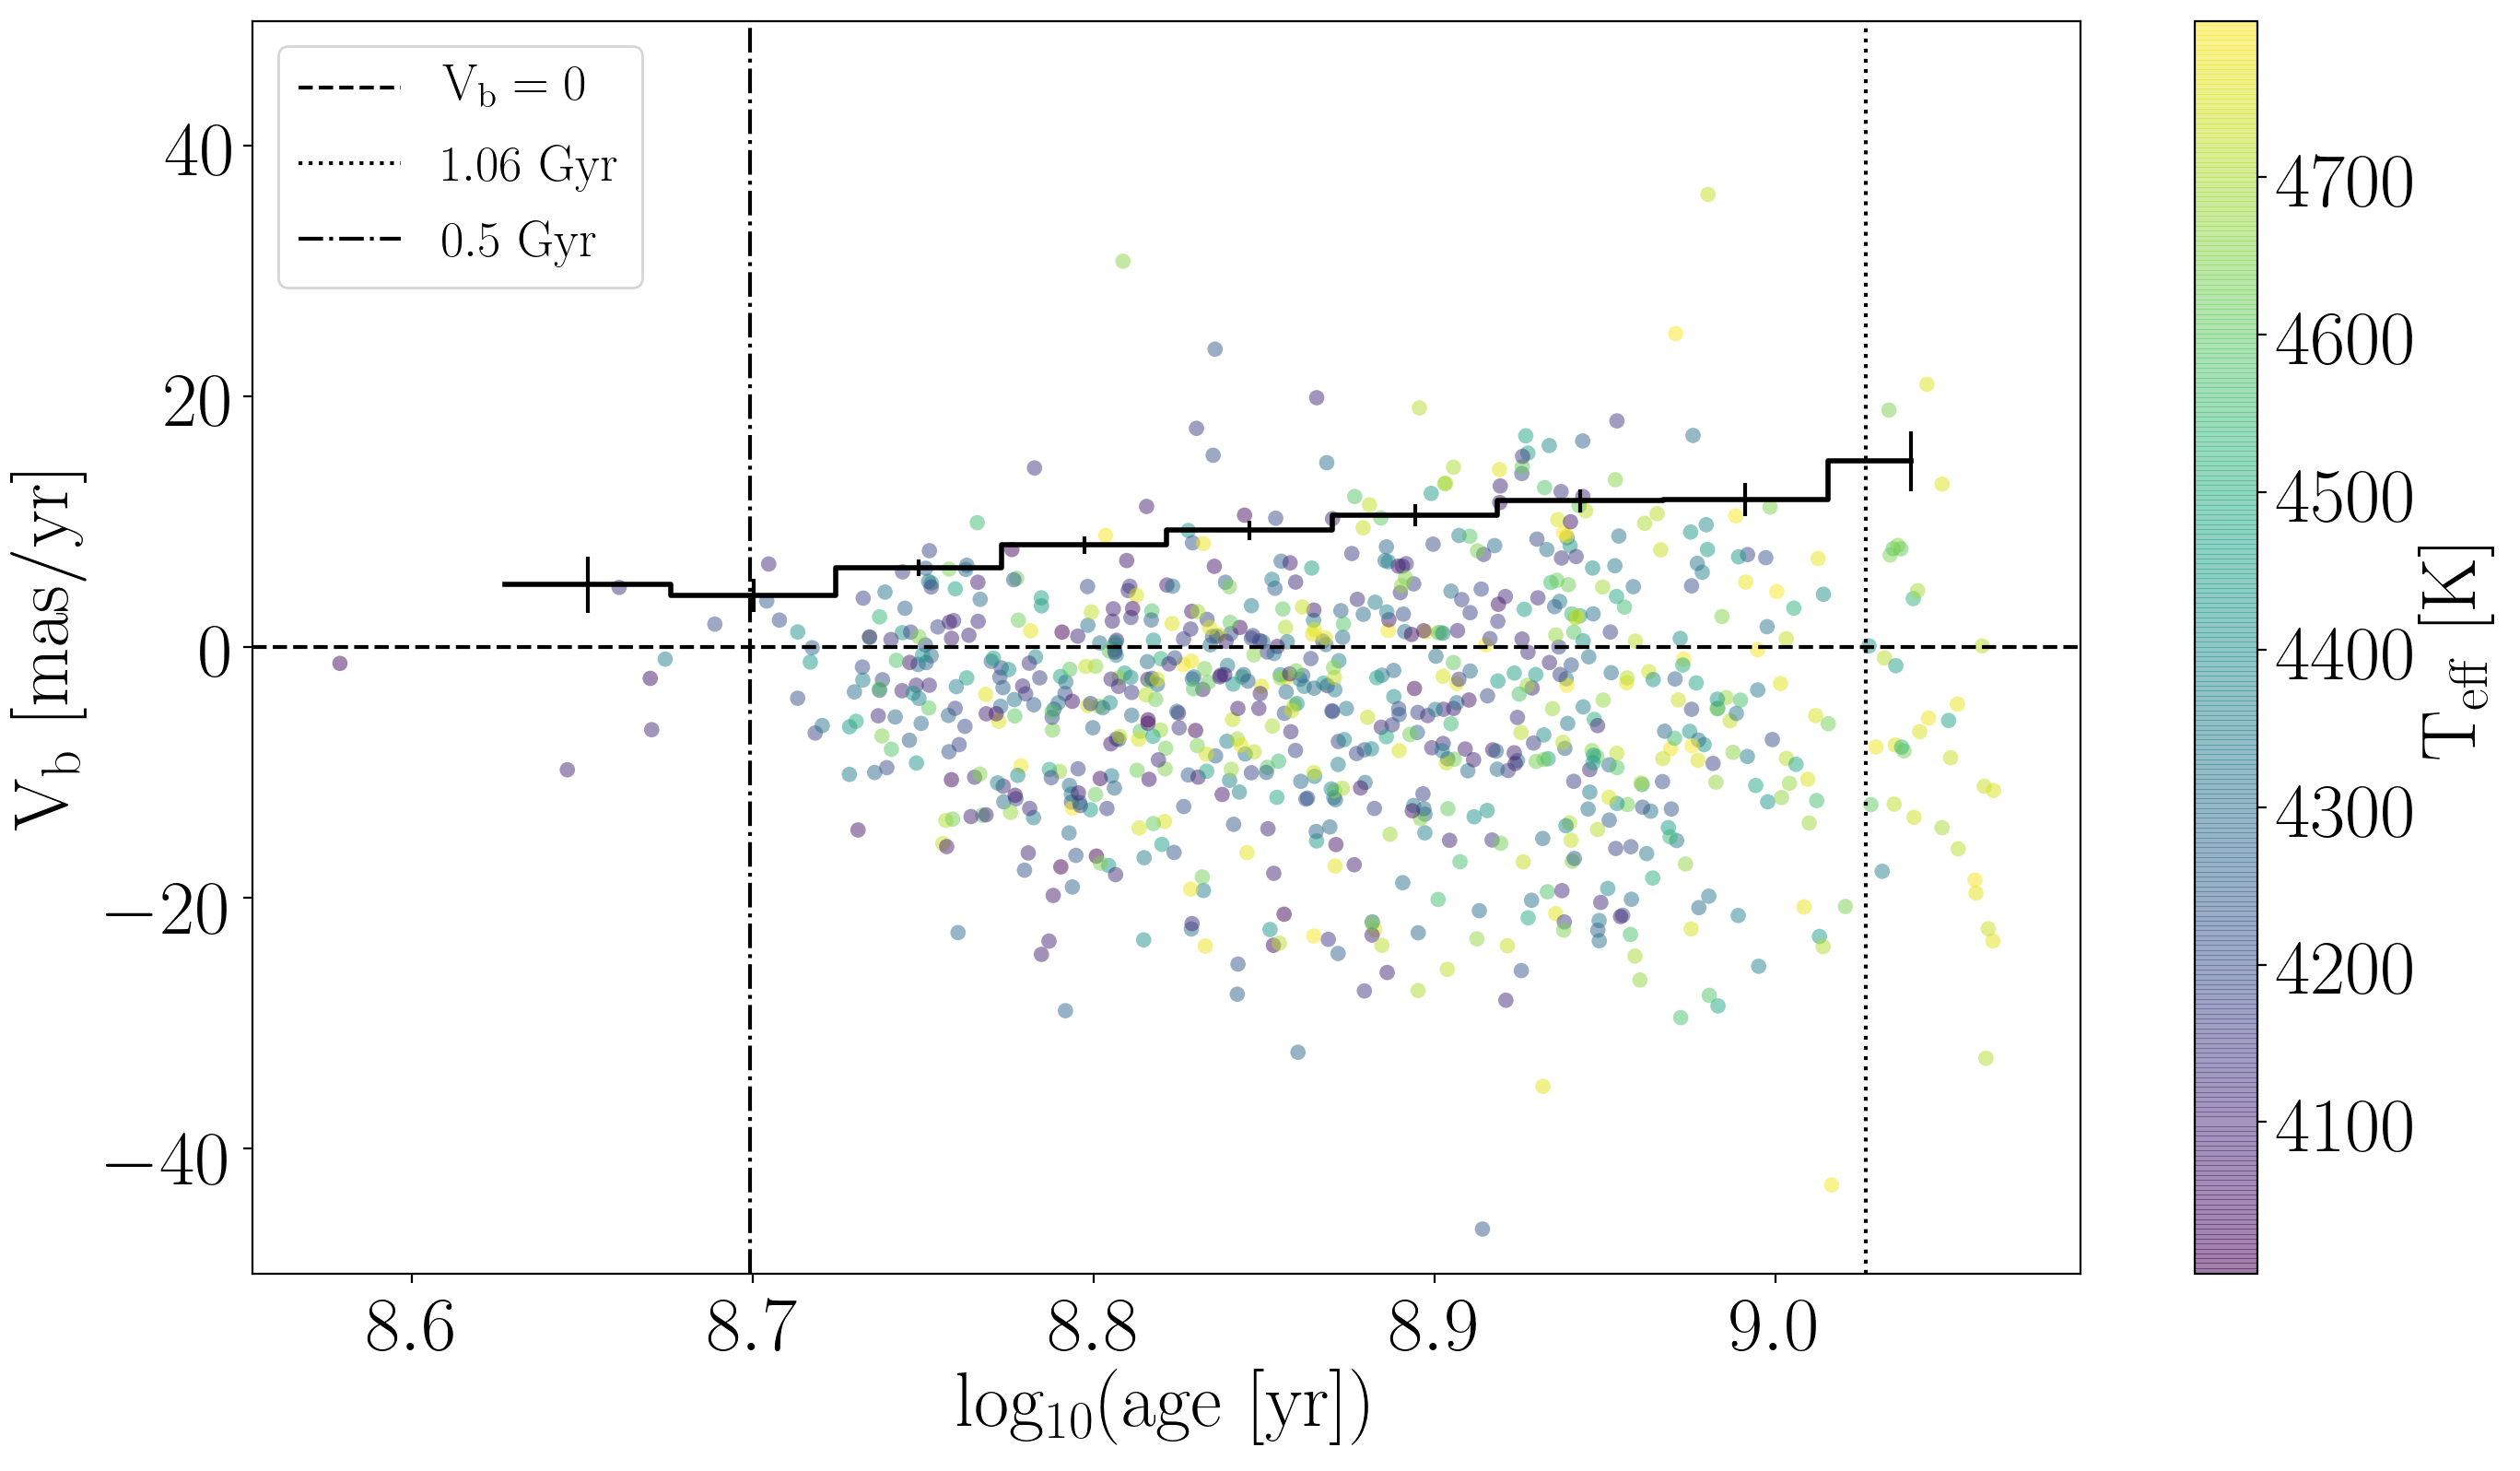

In [271]:
bins, dbins, err, mean = binned_dispersion(gmc.log_age.values[kstall], gmc.v_b.values[kstall], 10, method="std")

plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gmc.log_age.values[kstall], gmc.v_b.values[kstall], c=gmc.Teff.values[kstall],
            zorder=0, alpha=.5, edgecolor="none", rasterized=True)
plt.colorbar(label="$\mathrm{T_{eff}~[K]}$")
plt.step(bins, dbins, where="mid", lw=2, color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
plt.xlabel("$\mathrm{log_{10}(age~[yr])}$")
plt.ylabel("$\mathrm{V_b~[mas/yr]}$")
plt.axhline(0, color="k", ls="--", label="$\mathrm{V_b = 0}$")
plt.axvline(np.log10(1.06279416*1e9), color="k", ls=":", label="$\mathrm{1.06~Gyr}$")
plt.axvline(np.log10(.5*1e9), color="k", ls="-.", label="$\mathrm{0.5~Gyr}$")
plt.legend()

plt.ylim(-50, 50)

Look at stars a little bit hotter than this.

(-50, 50)

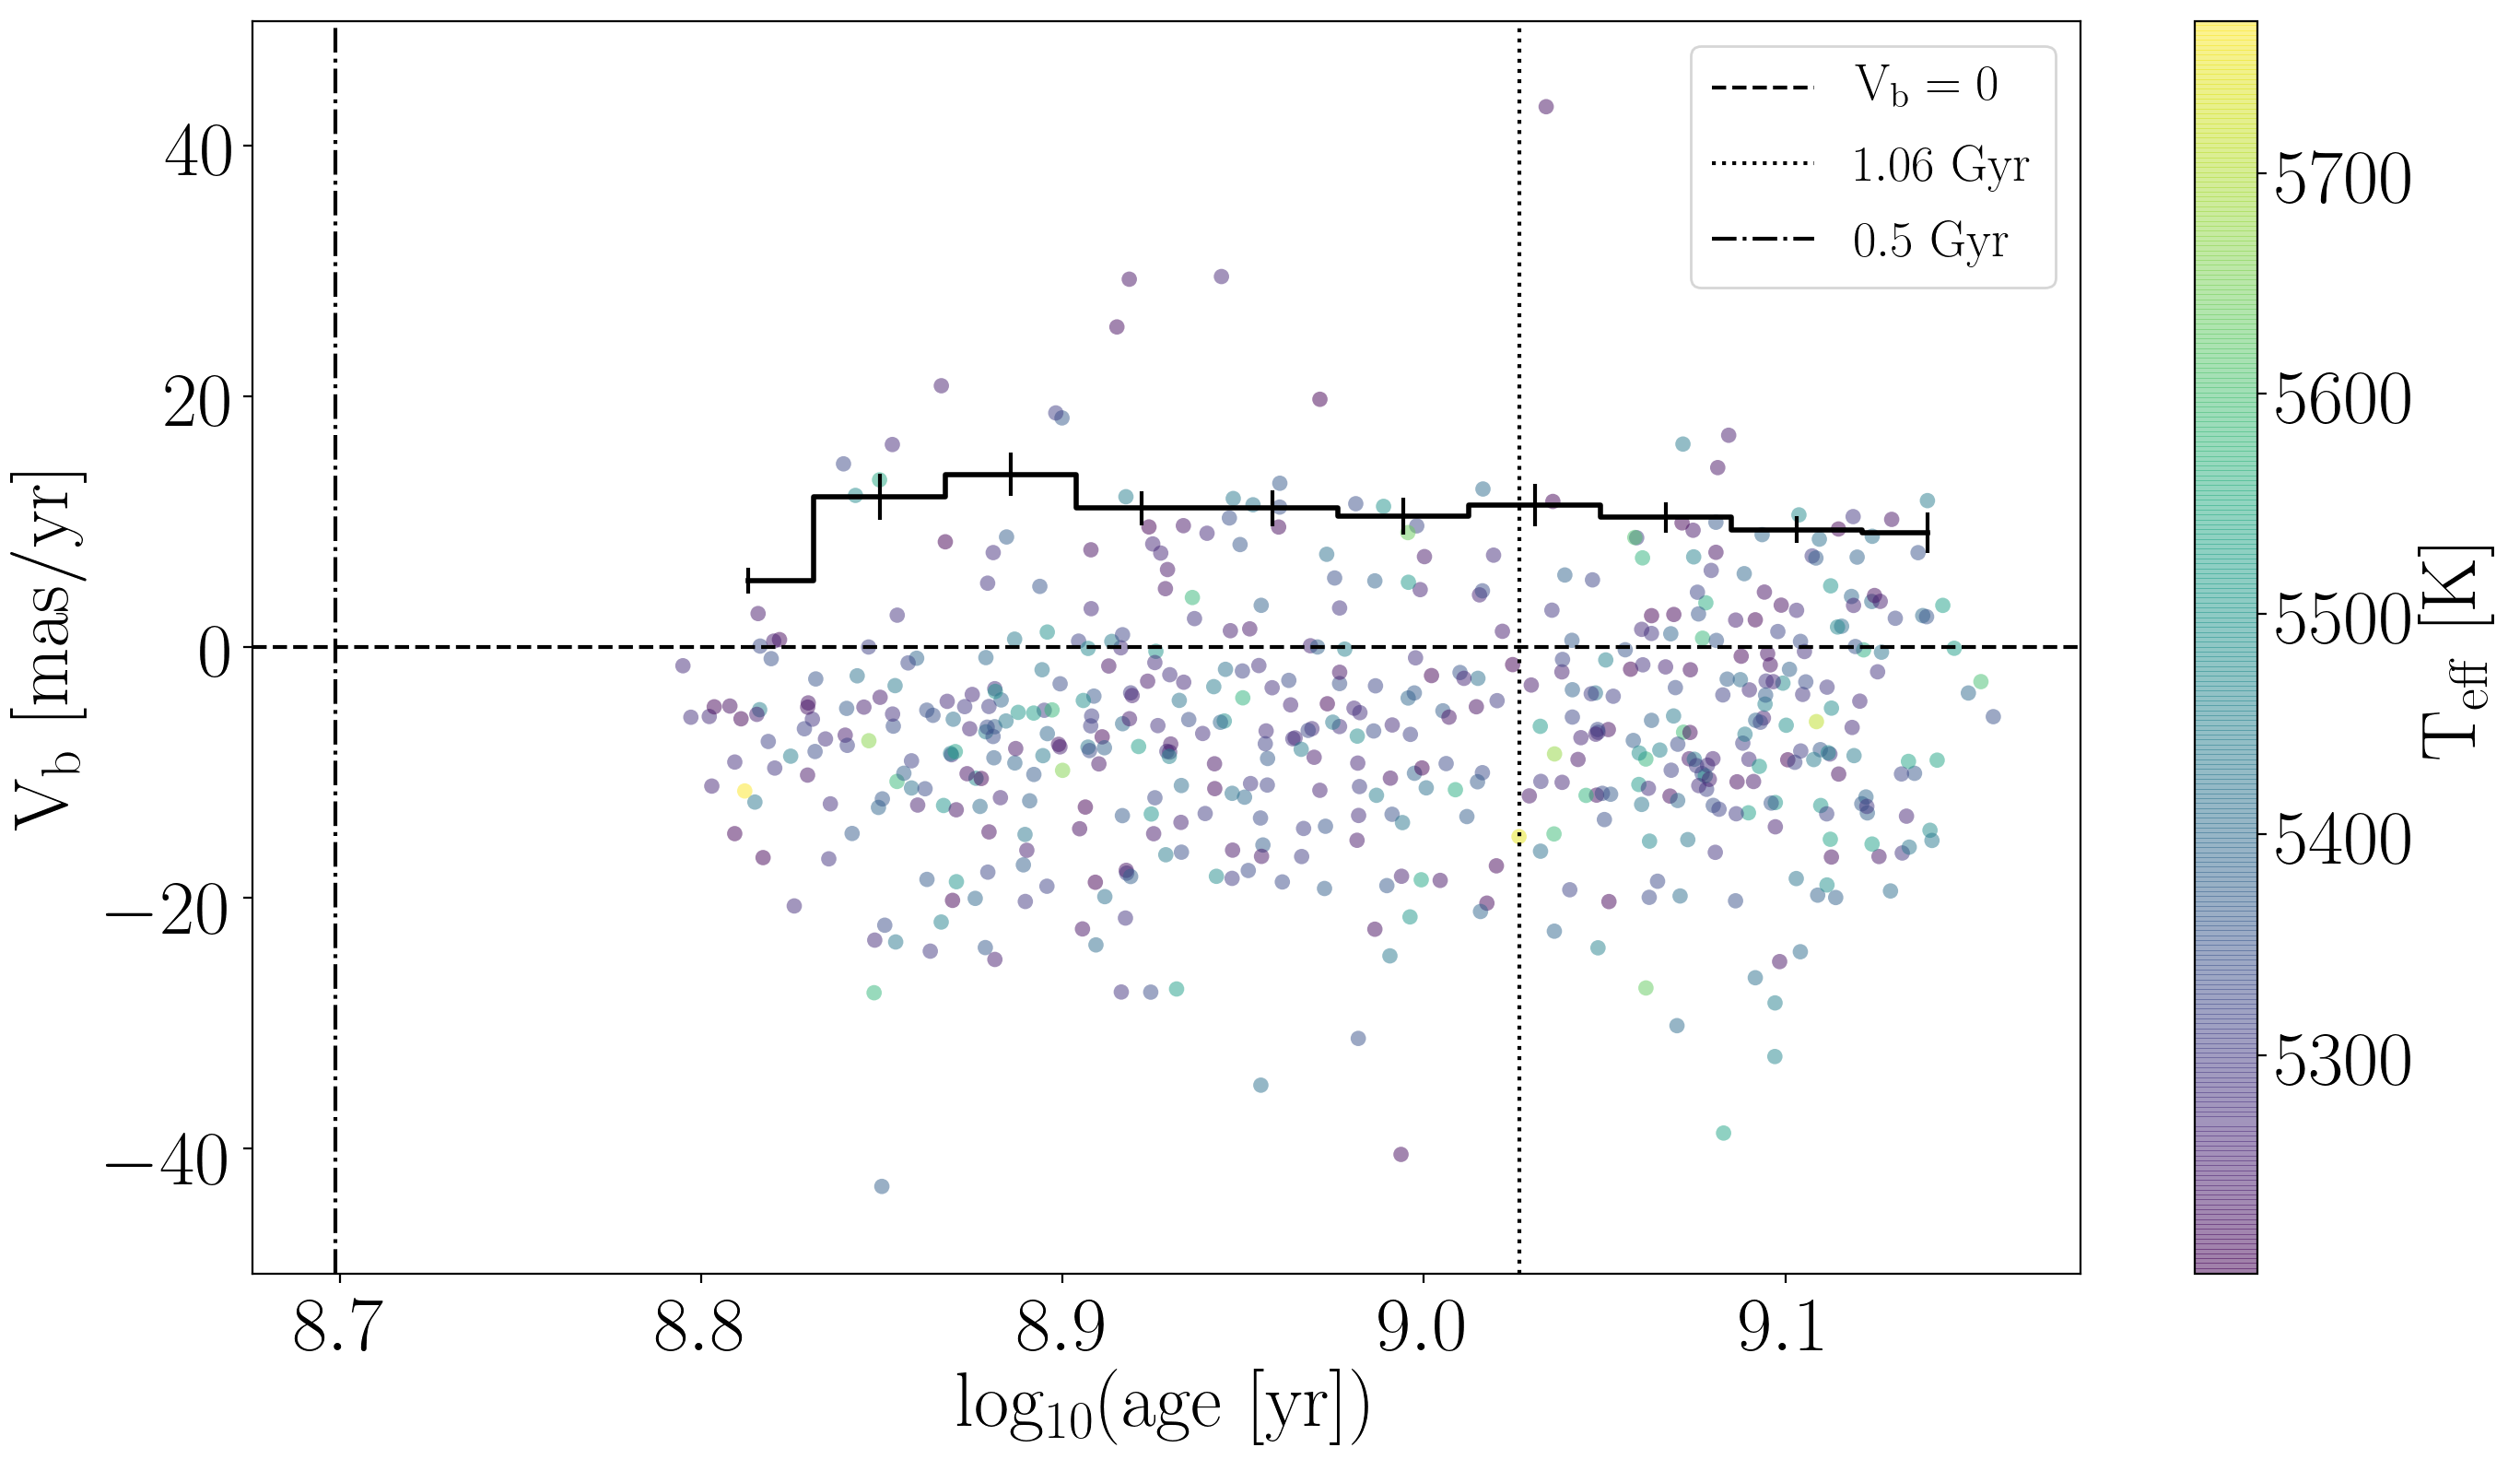

In [269]:
gmh = gaia_mc_hot.iloc[gstall]
bins, dbins, err, mean = binned_dispersion(gmh.log_age.values, gmh.v_b.values, 10, method="std")

plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gmh.log_age.values, gmh.v_b.values, c=gmh.Teff,
            zorder=0, alpha=.5, edgecolor="none", rasterized=True)
plt.colorbar(label="$\mathrm{T_{eff}~[K]}$")
plt.step(bins, dbins, where="mid", lw=2, color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
# plt.yscale("log")
plt.xlabel("$\mathrm{log_{10}(age~[yr])}$")
plt.ylabel("$\mathrm{V_b~[mas/yr]}$")
plt.axhline(0, color="k", ls="--", label="$\mathrm{V_b = 0}$")
plt.axvline(np.log10(1.06279416*1e9), color="k", ls=":", label="$\mathrm{1.06~Gyr}$")
plt.axvline(np.log10(.5*1e9), color="k", ls="-.", label="$\mathrm{0.5~Gyr}$")
plt.legend()

plt.ylim(-50, 50)

0.7943282347242822 1.9952623149688828 1.6595869074375633
1.0471285480508987
[1.06279416]


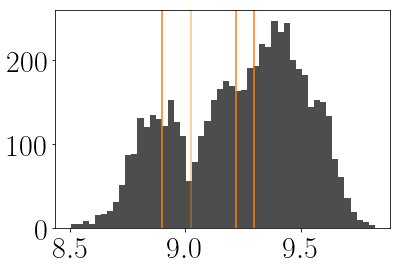

In [115]:
plt.hist(gmc.log_age.values, 50, color=".3");
plt.axvline(8.9, color="C1")
plt.axvline(9.3, color="C1")
plt.axvline(9.22, color="C1")
plt.axvline(9.025, color="C1", alpha=.5)
print((10**8.9)*1e-9, (10**9.3)*1e-9, (10**9.22)*1e-9)
print((10**9.02)*1e-9)

hist, bins = np.histogram(gmc.log_age.values, 300)
mbins = (bins[1:] > 8.8) * (bins[1:] < 9.1)
mmin = hist[mbins] == min(hist[mbins])
print((10**bins[1:][mbins][mmin])*1e-9)

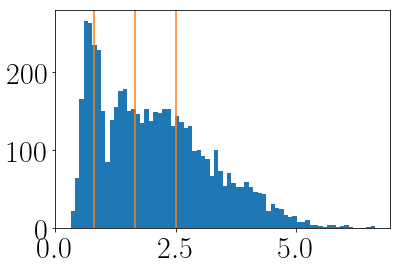

In [457]:
plt.hist((10**gmc.log_age.values)*1e-9, 70, color="");
plt.axvline(.8, color="C1")
plt.axvline(2.5, color="C1")
plt.axvline(1.65, color="C1")

Text(0, 0.5, '$\\mathrm{V_b}$')

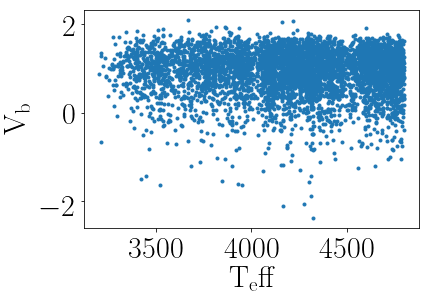

In [458]:
plt.plot(gmc.Teff, np.log10(abs(gmc.v_b.values)), ".")
plt.xlabel("$\mathrm{T_eff}$")
plt.ylabel("$\mathrm{V_b}$")

Text(0, 0.5, 'Teff [K]')

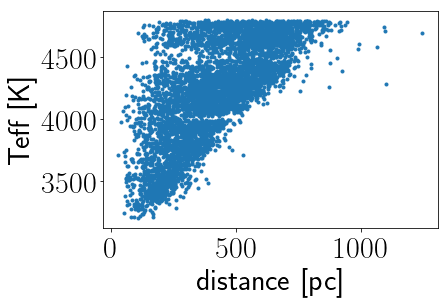

In [459]:
plt.plot((1./gmc.parallax)*1000, gmc.Teff, ".")
plt.xlabel("distance [pc]")
plt.ylabel("Teff [K]")

Text(0, 0.5, 'Vb')

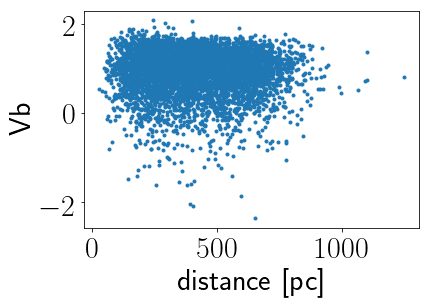

In [460]:
plt.plot((1./gmc.parallax)*1000, np.log10(abs(gmc.v_b.values)), ".")
plt.xlabel("distance [pc]")
plt.ylabel("Vb")

Plot the mean of velocities.

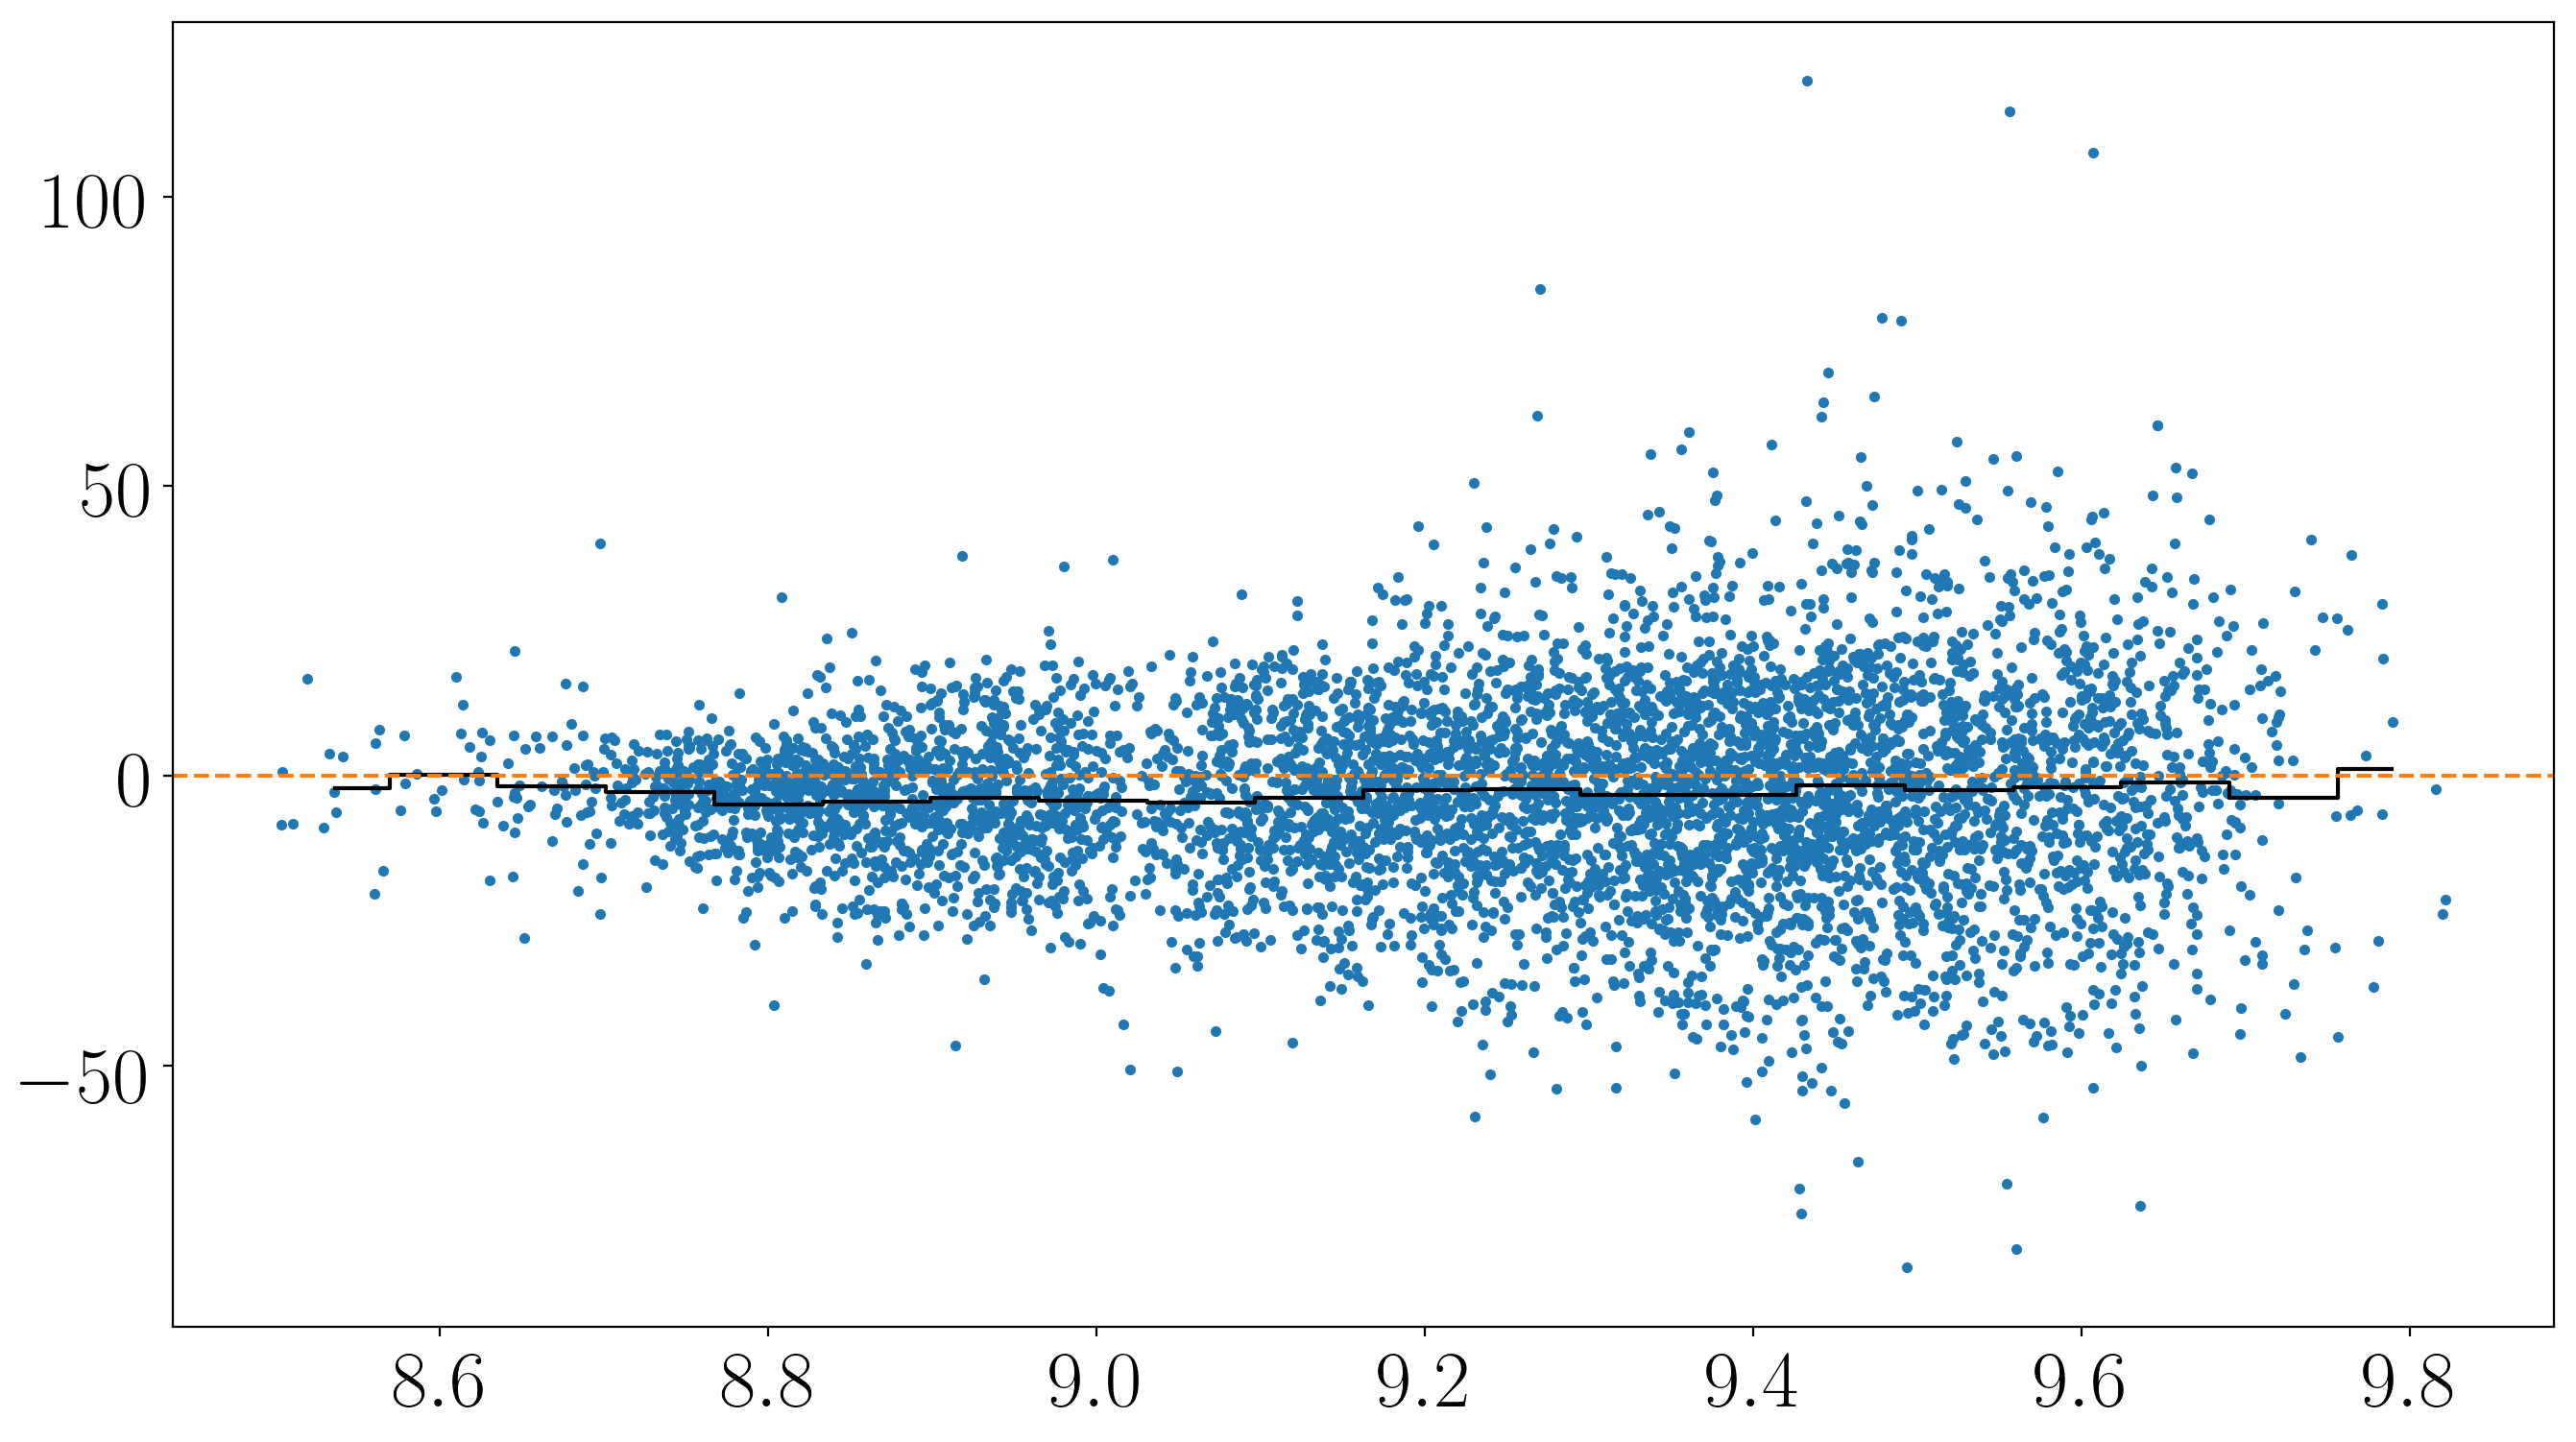

In [463]:
bins, rms, err, mean = binned_dispersion(gmc.log_age.values, gmc.v_b.values, 20, method="rms")
_, std, _, _ = binned_dispersion(gmc.log_age.values, gmc.v_b.values, 20, method="std")

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gmc.log_age.values, gmc.v_b.values, ".", zorder=0)
plt.step(bins, mean, where="mid", color="k")
plt.axhline(0, color="C1", ls="--")

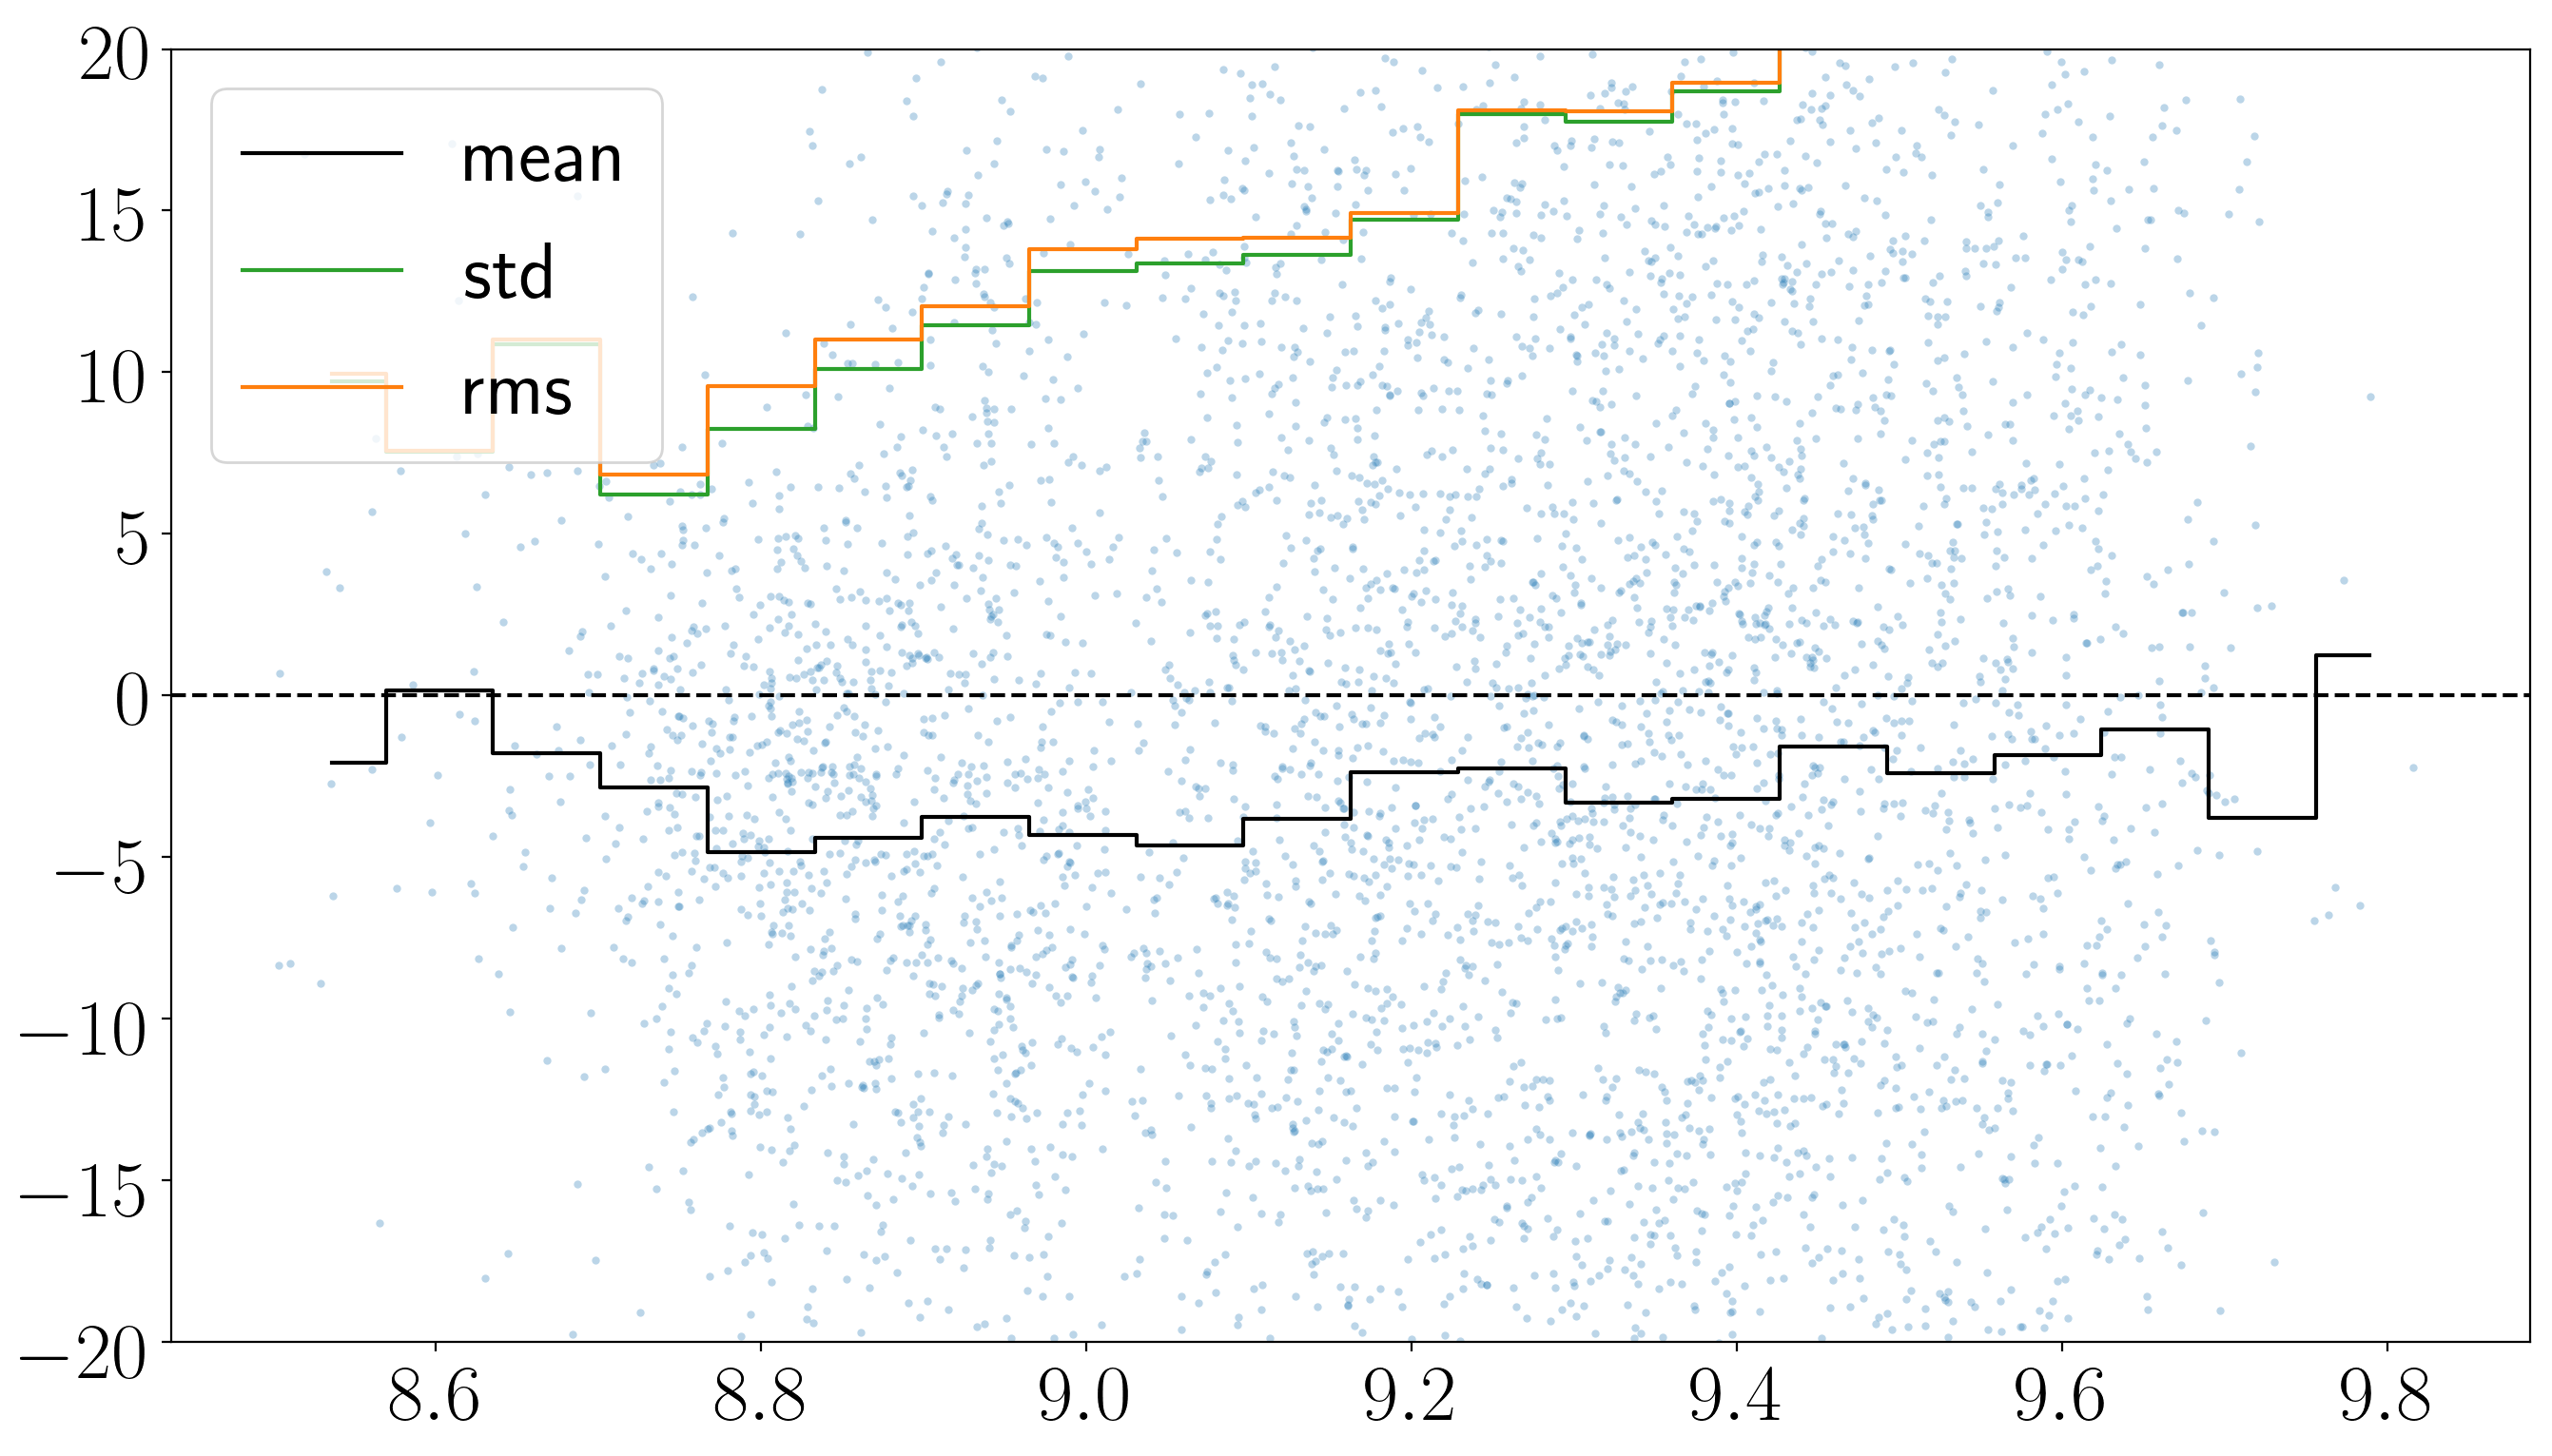

In [464]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(gmc.log_age.values, gmc.v_b.values,
         ".", zorder=0, alpha=.3, mec="none")
plt.step(bins, mean, where="mid", color="k", label="mean")
plt.step(bins, std, where="mid", color="C2", label="std")
plt.step(bins, rms, where="mid", color="C1", label="rms")
plt.axhline(0, color="k", ls="--")
plt.ylim(-20, 20)
plt.legend()

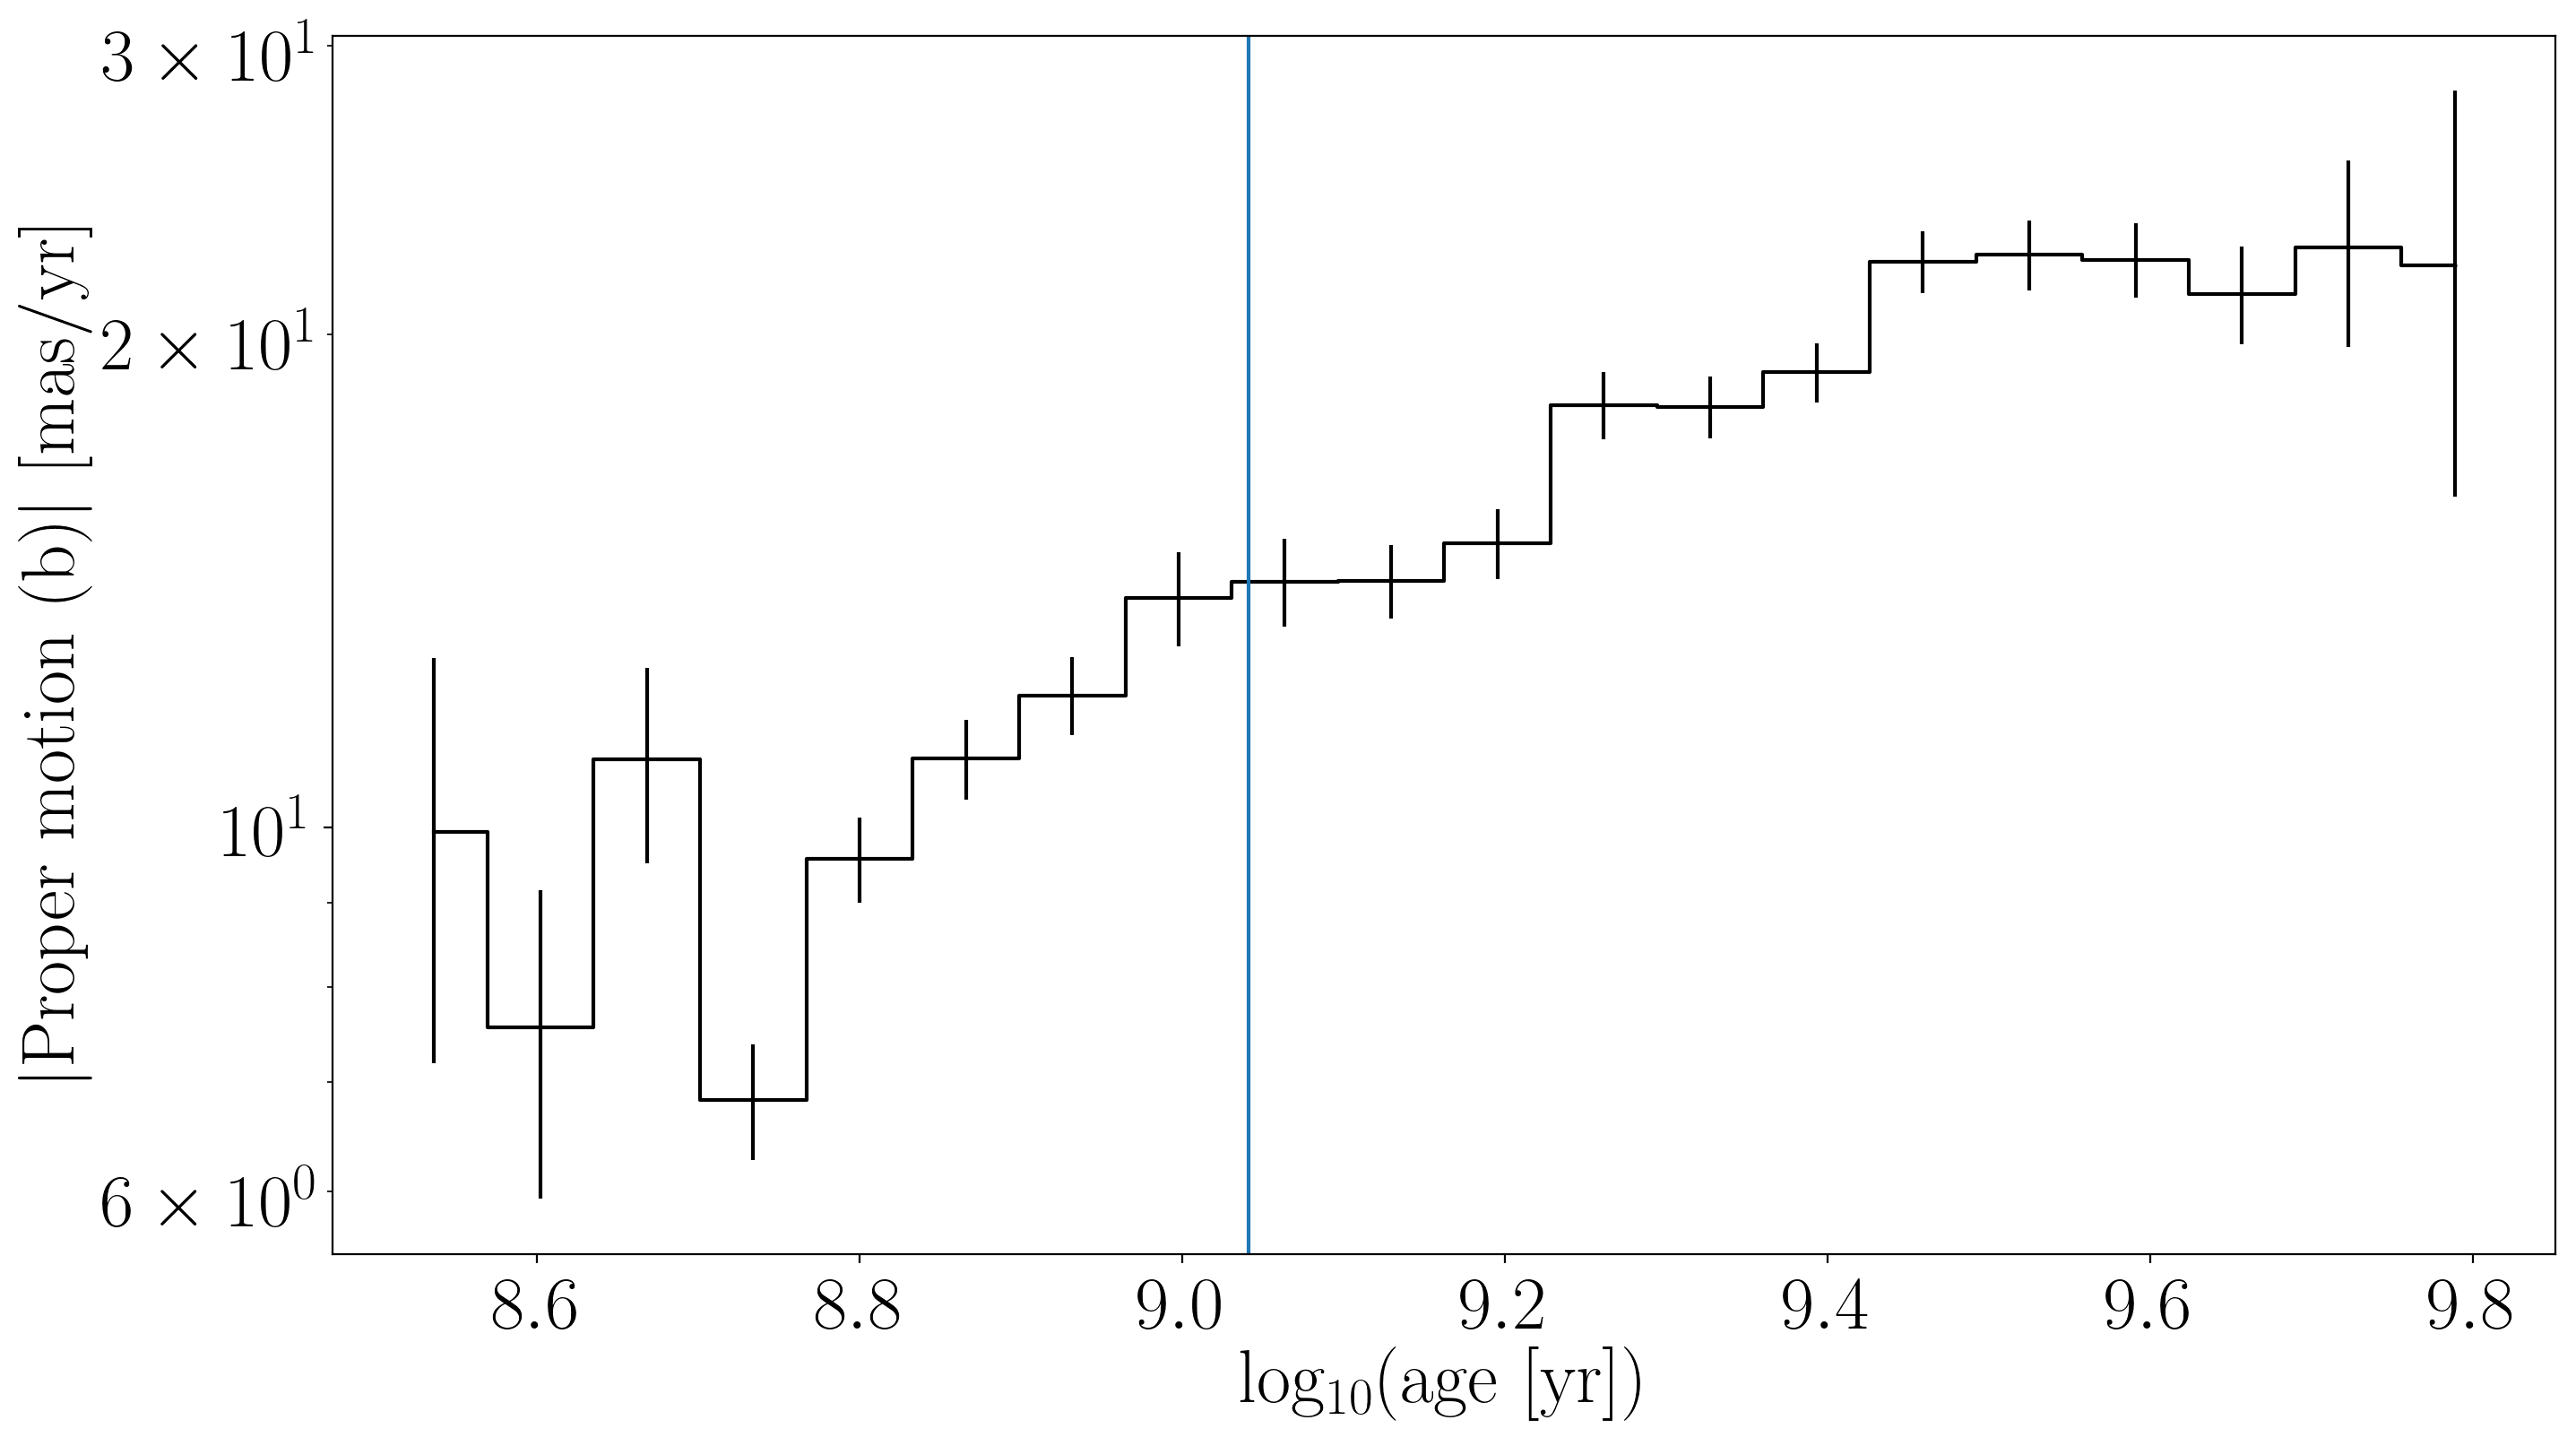

In [465]:
bins, dbins, err, mean = binned_dispersion(gmc.log_age.values, gmc.v_b.values, 20, method="rms")

plt.figure(figsize=(16, 9), dpi=200)
plt.step(bins, dbins, where="mid", color="k")
plt.errorbar(bins, dbins, yerr=err, fmt=".", color="k", ms=1)
plt.yscale("log")
plt.xlabel("$\mathrm{log_{10}(age~[yr])}$")
plt.ylabel("$\mathrm{|Proper~motion~(b)|~[mas/yr]}$")
plt.axvline(np.log10(1.1*1e9))
plt.savefig("rotation_pmb_dispersion.pdf")

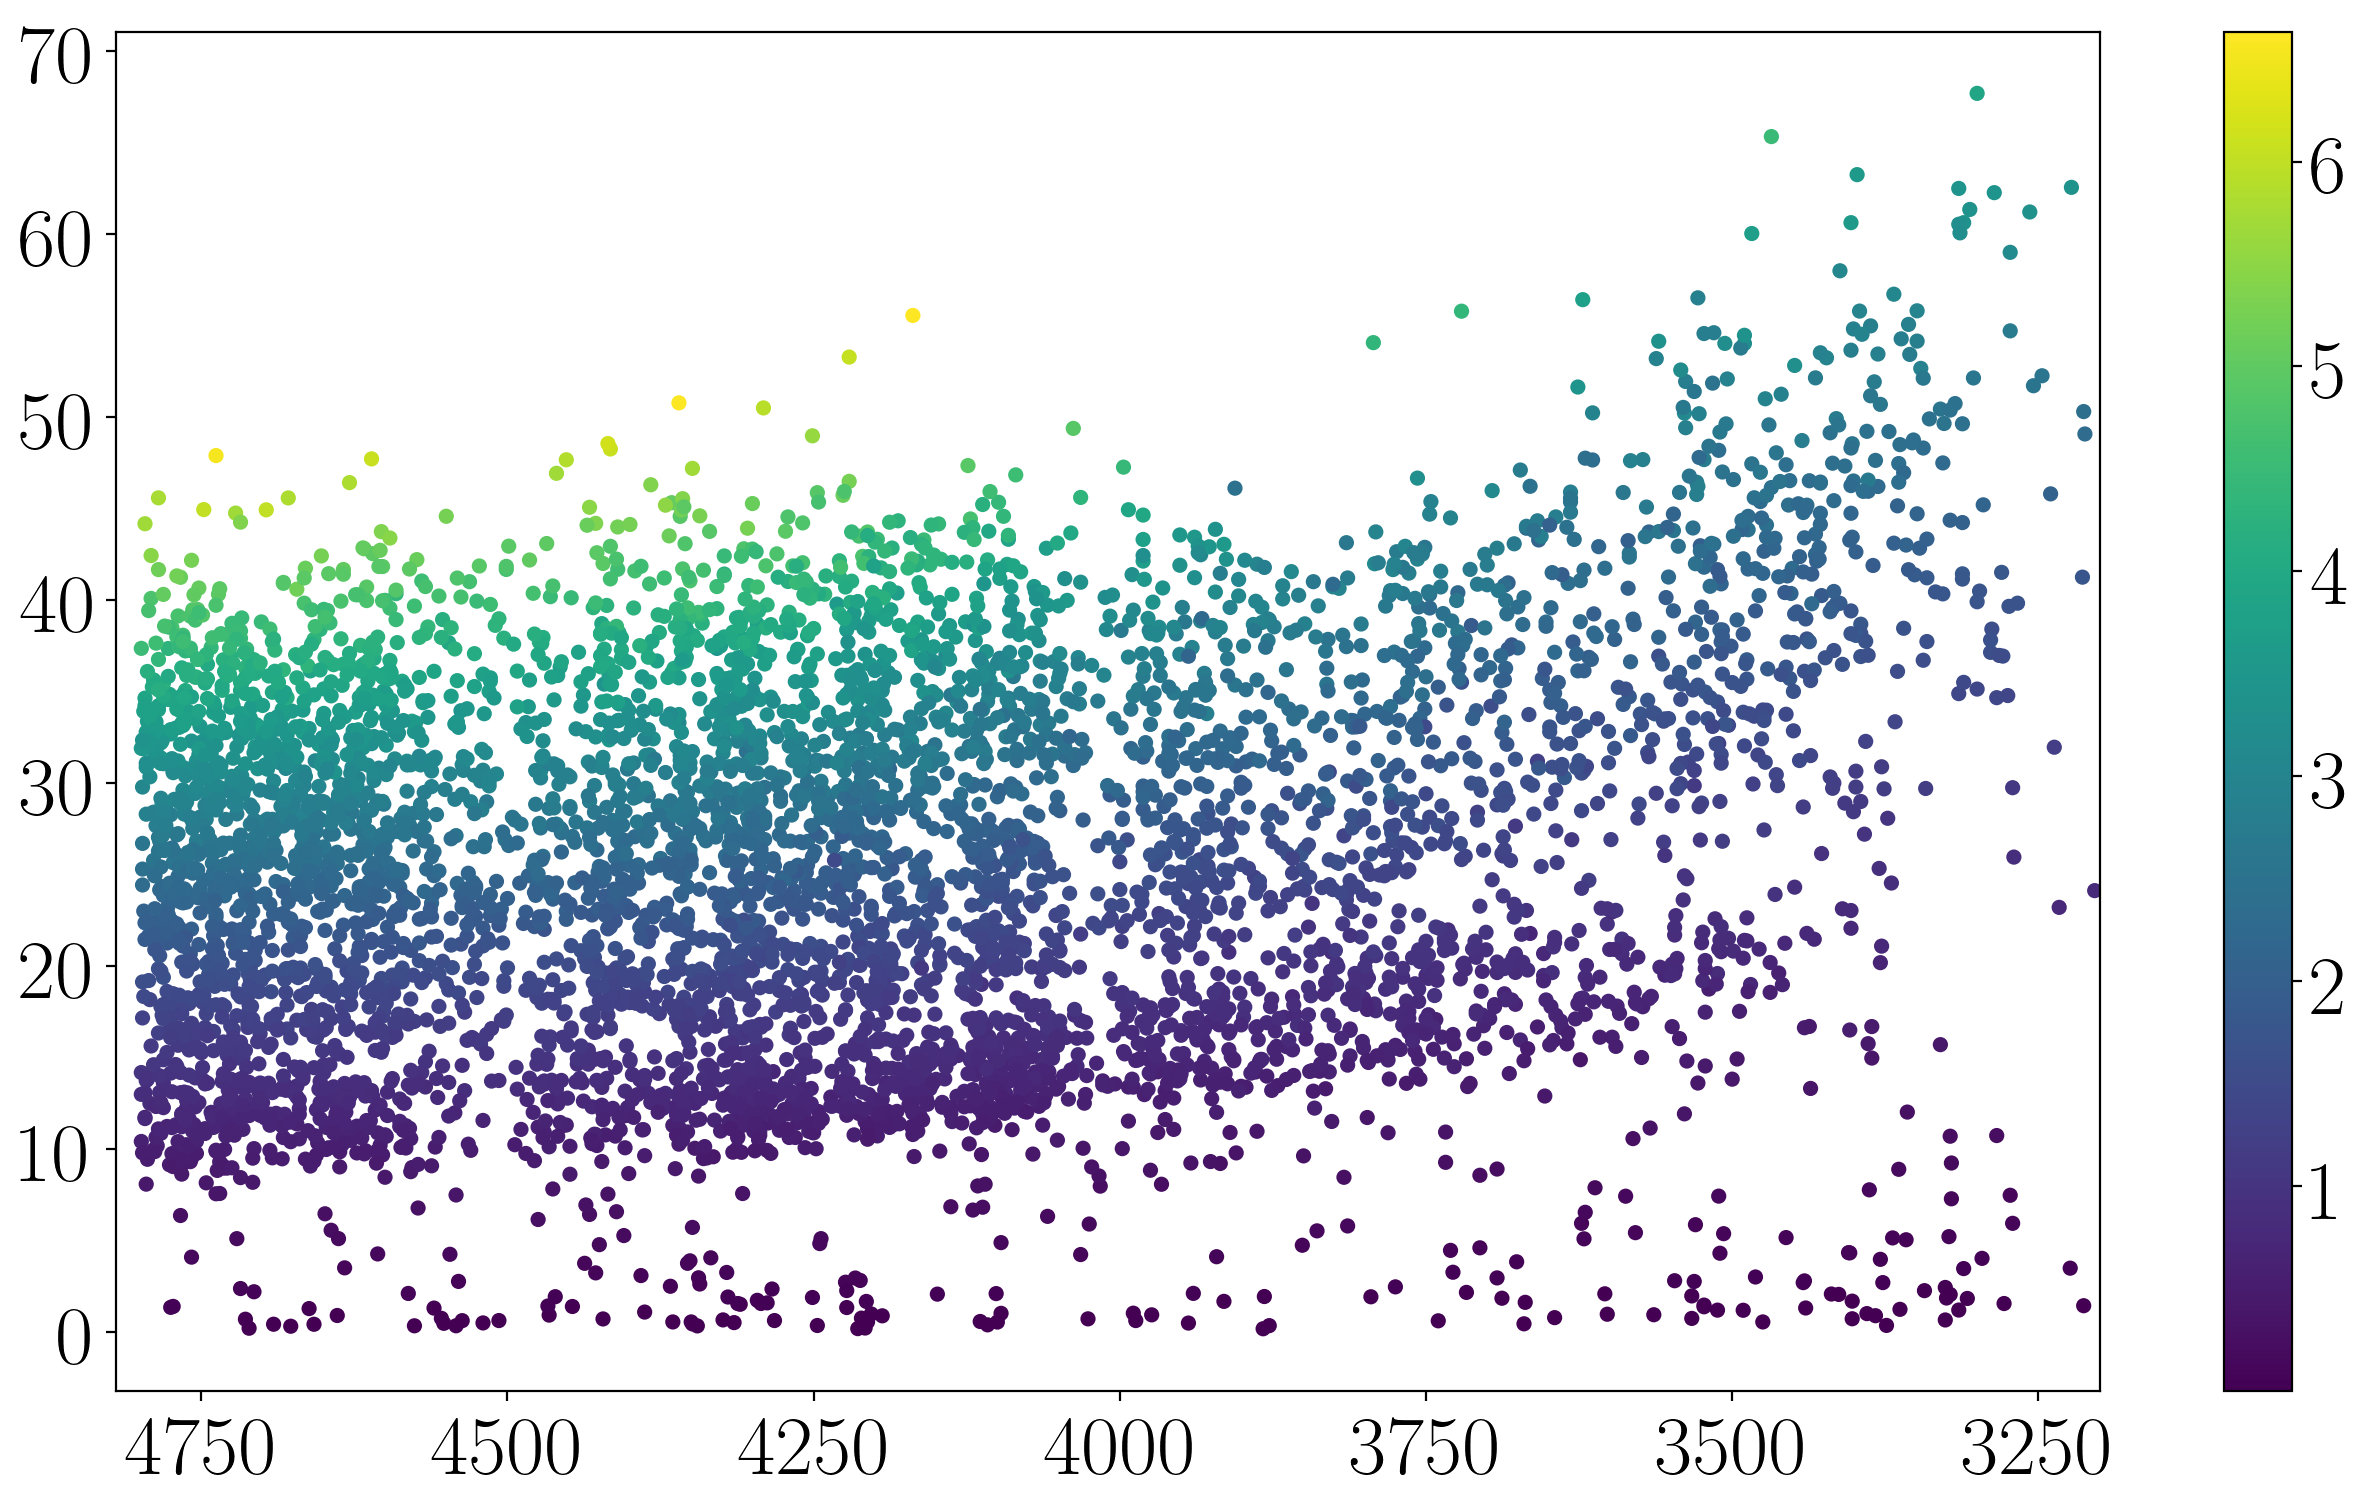

In [466]:
# Cool stars
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(gaia_mc_cool.Teff, gaia_mc_cool.Prot, c=gaia_mc_cool.age, s=20)
plt.xlim(4820, 3200)
plt.colorbar()

1) Calculate proper motions with uncertainties
2) Use Travis Berger's temperatures
3) Calculate actual ages
4) Keep writing words in tex document.
5) Use Bailer-Jones distances.